In [1]:
from flair.data import Sentence
from flair.models import SequenceTagger
tagger = SequenceTagger.load('flair/ner-english-ontonotes-fast')

2022-04-26 14:08:09,912 loading file /Users/rob/.flair/models/ner-english-ontonotes-fast/0d55dd3b912da9cf26e003035a0c269a0e9ab222f0be1e48a3bbba3a58c0fed0.c9907cd5fde3ce84b71a4172e7ca03841cd81ab71d13eb68aa08b259f57c00b6
2022-04-26 14:08:17,367 SequenceTagger predicts: Dictionary with 76 tags: <unk>, O, B-CARDINAL, E-CARDINAL, S-PERSON, S-CARDINAL, S-PRODUCT, B-PRODUCT, I-PRODUCT, E-PRODUCT, B-WORK_OF_ART, I-WORK_OF_ART, E-WORK_OF_ART, B-PERSON, E-PERSON, S-GPE, B-DATE, I-DATE, E-DATE, S-ORDINAL, S-LANGUAGE, I-PERSON, S-EVENT, S-DATE, B-QUANTITY, E-QUANTITY, S-TIME, B-TIME, I-TIME, E-TIME, B-GPE, E-GPE, S-ORG, I-GPE, S-NORP, B-FAC, I-FAC, E-FAC, B-NORP, E-NORP, S-PERCENT, B-ORG, E-ORG, B-LANGUAGE, E-LANGUAGE, I-CARDINAL, I-ORG, S-WORK_OF_ART, I-QUANTITY, B-MONEY


In [2]:
import pandas as pd
import numpy as np

import nltk

import spacy as sp
nlp = sp.load('en_core_web_sm')

In [3]:
dosage_df= pd.read_json('data/dosage-map.json')

In [4]:
dosage_df
dosage_df_modified=dosage_df[["prescriber_dosage"]]
dosage_df_modified

,prescriber_dosage
0,#take one daily
1,(!THIS IS CO-CODAMOL!!)TAKE 1 OR 2 UP TO 4 TIM...
2,(2mg) four BD PRN max 4mg/24hours
3,(Buprenorphine) Apply one patch and replace ev...
4,(Co-codamol 30/500) ONE or TWO caplets to be t...
...,...
2181,1 nocte## please do u&e twice a year in jan an...
2182,half tab nocte
2183,take two at night (total dose 700mg nocte)
2184,take one in the morning and one in the evening...


## Pre-processing:
- Convert everything to lowercase, remove special characters, tokenise.

I will try two different popular libraries - nltk and spacy, to decide which one to use for the pipeline.

Trying two different tokenizers as I'm having toruble with RegEx

In [5]:
tokenizer = nltk.RegexpTokenizer(r"[\w'-]+") #removes symbols and tokenizes
tokenizer2 = nltk.RegexpTokenizer(r"(?=\S*['(-|\/])([w'(-|\/]+)|[\w'-]+") # this one has issues with brackets
# tokenizer2 = nltk.RegexpTokenizer(r"(\d+|\D+)")
# tokenizer2 = nltk.RegexpTokenizer(r"(\d+|\D+)") 
tokens1 = []
tokens2 = []
processed_strings1 = []
processed_strings2 = []
for i in range(len(dosage_df_modified)):
    string = list(map(lambda x: x.casefold(), tokenizer.tokenize(dosage_df_modified.iloc[i]["prescriber_dosage"])))
    string2 = list(map(lambda x: x.casefold(), tokenizer2.tokenize(dosage_df_modified.iloc[i]["prescriber_dosage"])))
    # string=list(map(lambda X: tokenizer2.tokenize(X.casefold()), tokenizer.tokenize(dosage_df_modified.iloc[i]["prescriber_dosage"]))) #reduces to lower case
    # string=[item for sublist in string for item in sublist]
    tokens1.append(string)
    tokens2.append(string2)
    processed_strings1.append(' '.join(string))
    processed_strings2.append(' '.join(string2))

pre_processed_dosage_df = dosage_df_modified.__copy__()
pre_processed_dosage_df.loc[:,"string"]=np.array(processed_strings1, dtype=object)
# pre_processed_dosage_df.loc[:,"string2"]=np.array(processed_strings2, dtype=object)
# pre_processed_dosage_df.loc[:,"tokens1"]=np.array(tokens1, dtype=object)
# pre_processed_dosage_df.loc[:,"tokens2"]=np.array(tokens2, dtype=object)
pre_processed_dosage_df

,prescriber_dosage,string
0,#take one daily,take one daily
1,(!THIS IS CO-CODAMOL!!)TAKE 1 OR 2 UP TO 4 TIM...,this is co-codamol take 1 or 2 up to 4 times a...
2,(2mg) four BD PRN max 4mg/24hours,2mg four bd prn max 4mg 24hours
3,(Buprenorphine) Apply one patch and replace ev...,buprenorphine apply one patch and replace ever...
4,(Co-codamol 30/500) ONE or TWO caplets to be t...,co-codamol 30 500 one or two caplets to be tak...
...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,1 nocte please do u e twice a year in jan and ...
2182,half tab nocte,half tab nocte
2183,take two at night (total dose 700mg nocte),take two at night total dose 700mg nocte
2184,take one in the morning and one in the evening...,take one in the morning and one in the evening...


### Review-SpaCy
It would appear that spaCy is much more easy to use than nltk and much more powerful in terms of out of the box NER (nltk only supports 3 tags whereas spaCy supports 18 tags), from now on I will use spaCy for all basic NLP purposes. I will also experiment with Flair and see how that performs. As seen above, SpaCy cannot identify all entities correctly - datapoint 2185 for example. This may be improved by better pre-processing. 

### NER with Flair

In [6]:
lemmas_df = []
pos_tags_df = []
tag_df = []
norm_df = []
ents_df = []
for i in range(len(pre_processed_dosage_df["string"])):
    string = nlp(pre_processed_dosage_df["string"].iloc[i])
    lemmas = []
    pos_tags = []
    tag = []
    norm = []
    ents = []
    for token in string:
        lemmas.append(token.lemma_)
        pos_tags.append(token.pos_)
        tag.append(token.tag_)
        norm.append(token.norm_)

    for entity in string.ents:
        ents.append((str(entity.text), str(entity.label_)))

    lemmas_df.append(lemmas)
    pos_tags_df.append(pos_tags)
    tag_df.append(pos_tags)
    norm_df.append(norm)
    ents_df.append(ents)

ner_df = pre_processed_dosage_df.__copy__()
ner_df.loc[:,"spacy_entities"] = ents_df

ents_df = []
for i in range(len(pre_processed_dosage_df)):
    string = Sentence(pre_processed_dosage_df["string"].iloc[i])
    # load the NER tagger

    # run NER over sentence
    tagger.predict(string)
    ents = [(entity.text, entity.get_label("ner").value) for entity in string.get_spans('ner')] #getting NER spans
    ents_df.append(ents)

# pre_processed_dosage_df = dosage_df_modified.__copy__()
# pre_processed_dosage_df.loc[:,"lemmas"] = lemmas_df
# pre_processed_dosage_df.loc[:,"pos_tags"] = pos_tags_df
# pre_processed_dosage_df.loc[:,"tags"] = tag_df
# pre_processed_dosage_df.loc[:,"norms"] = norm_df
ner_df.loc[:,"flair_entities"] = ents_df
ner_df

,prescriber_dosage,string,spacy_entities,flair_entities
0,#take one daily,take one daily,"[(one, CARDINAL), (daily, DATE)]","[(one, CARDINAL)]"
1,(!THIS IS CO-CODAMOL!!)TAKE 1 OR 2 UP TO 4 TIM...,this is co-codamol take 1 or 2 up to 4 times a...,"[(1, CARDINAL), (8, CARDINAL), (24hrs, CARDINAL)]","[(1, CARDINAL), (2, CARDINAL), (4, CARDINAL), ..."
2,(2mg) four BD PRN max 4mg/24hours,2mg four bd prn max 4mg 24hours,"[(2, CARDINAL)]","[(four, CARDINAL)]"
3,(Buprenorphine) Apply one patch and replace ev...,buprenorphine apply one patch and replace ever...,"[(one, CARDINAL), (every 7 days, DATE)]","[(one, CARDINAL), (7 days, DATE)]"
4,(Co-codamol 30/500) ONE or TWO caplets to be t...,co-codamol 30 500 one or two caplets to be tak...,"[(one, CARDINAL), (two, CARDINAL), (4-6 hours,...","[(30, CARDINAL), (500, CARDINAL), (one, CARDIN..."
...,...,...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,1 nocte please do u e twice a year in jan and ...,"[(1, CARDINAL), (u e twice a year, ORG), (jan ...","[(1, CARDINAL)]"
2182,half tab nocte,half tab nocte,"[(half, CARDINAL)]",[]
2183,take two at night (total dose 700mg nocte),take two at night total dose 700mg nocte,"[(two, CARDINAL), (700, CARDINAL), (nocte, ORG)]","[(two, CARDINAL)]"
2184,take one in the morning and one in the evening...,take one in the morning and one in the evening...,"[(one, CARDINAL), (50, CARDINAL), (nocte, ORG)]",[]


Take random sample, for annotation. 

In [7]:
pre_processed_dosage_df

,prescriber_dosage,string
0,#take one daily,take one daily
1,(!THIS IS CO-CODAMOL!!)TAKE 1 OR 2 UP TO 4 TIM...,this is co-codamol take 1 or 2 up to 4 times a...
2,(2mg) four BD PRN max 4mg/24hours,2mg four bd prn max 4mg 24hours
3,(Buprenorphine) Apply one patch and replace ev...,buprenorphine apply one patch and replace ever...
4,(Co-codamol 30/500) ONE or TWO caplets to be t...,co-codamol 30 500 one or two caplets to be tak...
...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,1 nocte please do u e twice a year in jan and ...
2182,half tab nocte,half tab nocte
2183,take two at night (total dose 700mg nocte),take two at night total dose 700mg nocte
2184,take one in the morning and one in the evening...,take one in the morning and one in the evening...


In [8]:
random_indices = [22, 37, 88, 102, 195, 203, 290, 333, 381, 383, 427, 490, 507, 514, 543, 576, 696, 715, 748, 843, 901, 936, 941, 971, 1013, 1024, 1047, 1053, 1121, 1129, 1173, 1232, 1322, 1406, 1433, 1455, 1575, 1589, 1593, 1608, 1646, 1673, 1696, 1705, 1718, 1749, 1880, 1965, 1984, 2091]
# pre_processed_dosage_df.iloc[random_indices][['prescriber_dosage', 'string']].to_csv('data/random_sample.csv')
#preparing for annotion with doccanno
training_data = pre_processed_dosage_df.iloc[random_indices][['string']] # trying with standardised string first
training_data['label']=np.nan
training_data.columns = ['text', 'label']
# training_data.to_json(path_or_buf='training_data.json', orient='records')

Important notes: 
- Using Docanno for NER annotation of training set
- Medical abbreviations are an issue
- Other important instructions are being ignored for now "take only when needed", only focusing on frequency and mealtimes for now.

After annotation:

In [9]:
annotated_data=pd.read_json('data/training_data_annotated_v1.json', orient='records')
annotated_data.drop(["id"], inplace=True, axis=1)
annotated_data.columns = ['text', 'annotation']
training = annotated_data.iloc[:80]
test = annotated_data.iloc[80:87]
dev = annotated_data.iloc[87:]

This code is copied from: https://medium.com/thecyphy/training-custom-ner-model-using-flair-df1f9ea9c762 and adapted for my purposes.

Creating training data for corpus

In [10]:
from difflib import SequenceMatcher

def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)
    return match_list, string

def matcher_indices(string: str, annotations):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match = (annotations[0], annotations[1])
    string = string.replace(string[match[0]: match[1]], 'X' * (match[1]-match[0]),1)
    return [match], string

def mark_sentence(s, match_list):
    '''
    Marks all the entities in the sentence as per the BIO scheme. 
    '''
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'
        
    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def clean(text): #not really relevant
    '''
    Just a helper fuction to add a space before the punctuations for better tokenization
    '''
    filters = ["!", "#", "$", "%", "&", "(", ")", "/", "*", ".", ":", ";", "<", "=", ">", "?", "@", "[",
               "\\", "]", "_", "`", "{", "}", "~", "'"]
    for i in text:
        if i in filters:
            text = text.replace(i, " " + i)
            
    return text

def create_data(df, filepath):
    '''
    The function responsible for the creation of data in the said format.
    '''
    with open(filepath , 'w') as f:
        for text, annotation in zip(df.text, df.annotation):
            # text = clean(text)
            text_ = text        
            match_list = []
            for i in annotation:
                # a, text_ = matcher(text, i[0])
                a, text_ = matcher_indices(text, i)
                match_list.append((a[0][0], a[0][1], i[2]))
                
            d = mark_sentence(text, match_list)

            for i in d.keys():
                f.writelines(i + ' ' + d[i] +'\n')
            f.writelines('\n')

This is an example I ran so I could gain a better understanding of how the functino worked so I could adapt it to my data

In [11]:
def main():
    ## An example dataframe.
    # data = pd.DataFrame([["Horses are too tall and they pretend to care about your feelings", [("Horses", "ANIMAL")]],
    #               ["Who is Shaka Khan?", [("Shaka Khan", "PERSON")]],
    #               ["I like London and Berlin.", [("London", "LOCATION"), ("Berlin", "LOCATION")]],
    #               ["There is a banyan tree in the courtyard", [("banyan tree", "TREE")]]], columns=['text', 'annotation'])
    
    ## path to save the txt file.
    filepath = 'custom_model/dev.txt'
    ## creating the file.
    create_data(dev, filepath)

# main()


In [12]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

columns = {0: 'text', 1: 'ner'}

data_folder = 'custom_model'

corpus : Corpus = ColumnCorpus(data_folder, columns,
                                train_file='train.txt',
                                test_file='test.txt',
                                dev_file='dev.txt')

2022-04-26 14:10:30,519 Reading data from custom_model
2022-04-26 14:10:30,520 Train: custom_model/train.txt
2022-04-26 14:10:30,520 Dev: custom_model/dev.txt
2022-04-26 14:10:30,520 Test: custom_model/test.txt


In [13]:
# tag to predict
tag_type = 'ner'
# make tag dictionary from the corpus
tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)

from flair.embeddings import WordEmbeddings, StackedEmbeddings, TokenEmbeddings
from typing import List

glove_embedding = WordEmbeddings('glove')

fasttext_embeddings = WordEmbeddings('en')

embeddings : StackedEmbeddings = StackedEmbeddings([glove_embedding])
 
from flair.models import SequenceTagger
tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)

2022-04-26 14:10:30,557 Computing label dictionary. Progress:


80it [00:00, 18677.67it/s]

2022-04-26 14:10:30,632 Dictionary created for label 'ner' with 4 values: FREQUENCY (seen 76 times), QUANTITY (seen 68 times), MEALTIME (seen 8 times)


2022-04-26 14:10:42,968 SequenceTagger predicts: Dictionary with 13 tags: O, S-FREQUENCY, B-FREQUENCY, E-FREQUENCY, I-FREQUENCY, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, S-MEALTIME, B-MEALTIME, E-MEALTIME, I-MEALTIME


In [14]:
# training the model
from flair.trainers import ModelTrainer
trainer : ModelTrainer = ModelTrainer(tagger, corpus)
# TRAINED
# trainer.train('models/resources/taggers/ner',
#               learning_rate=0.1,
#               mini_batch_size=32,
#               max_epochs=150)

In [15]:
model = SequenceTagger.load('models/resources/taggers/ner/best-model.pt')
ents_df = []
for i in range(len(pre_processed_dosage_df)):
    string = Sentence(pre_processed_dosage_df["string"].iloc[i])
    # load the NER tagger

    # run NER over sentence
    model.predict(string)
    ents = [(entity.text, entity.get_label("ner").value) for entity in string.get_spans('ner')] #getting NER spans
    ents_df.append(ents)

ner_df.loc[:,"custom_entities"] = ents_df
ner_df

2022-04-26 14:10:43,052 loading file models/resources/taggers/ner/best-model.pt
2022-04-26 14:10:43,584 SequenceTagger predicts: Dictionary with 10 tags: <unk>, B-QUANTITY, I-QUANTITY, B-FREQUENCY, I-FREQUENCY, O, B-MEALTIME, I-MEALTIME, <START>, <STOP>


,prescriber_dosage,string,spacy_entities,flair_entities,custom_entities
0,#take one daily,take one daily,"[(one, CARDINAL), (daily, DATE)]","[(one, CARDINAL)]","[(one daily, FREQUENCY)]"
1,(!THIS IS CO-CODAMOL!!)TAKE 1 OR 2 UP TO 4 TIM...,this is co-codamol take 1 or 2 up to 4 times a...,"[(1, CARDINAL), (8, CARDINAL), (24hrs, CARDINAL)]","[(1, CARDINAL), (2, CARDINAL), (4, CARDINAL), ...","[(this, QUANTITY), (1, QUANTITY), (2, QUANTITY..."
2,(2mg) four BD PRN max 4mg/24hours,2mg four bd prn max 4mg 24hours,"[(2, CARDINAL)]","[(four, CARDINAL)]","[(four, QUANTITY)]"
3,(Buprenorphine) Apply one patch and replace ev...,buprenorphine apply one patch and replace ever...,"[(one, CARDINAL), (every 7 days, DATE)]","[(one, CARDINAL), (7 days, DATE)]","[(7 days, FREQUENCY)]"
4,(Co-codamol 30/500) ONE or TWO caplets to be t...,co-codamol 30 500 one or two caplets to be tak...,"[(one, CARDINAL), (two, CARDINAL), (4-6 hours,...","[(30, CARDINAL), (500, CARDINAL), (one, CARDIN...","[(co-codamol 30, QUANTITY), (500, MEALTIME), (..."
...,...,...,...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,1 nocte please do u e twice a year in jan and ...,"[(1, CARDINAL), (u e twice a year, ORG), (jan ...","[(1, CARDINAL)]","[(1, QUANTITY), (twice a, FREQUENCY)]"
2182,half tab nocte,half tab nocte,"[(half, CARDINAL)]",[],"[(half, QUANTITY)]"
2183,take two at night (total dose 700mg nocte),take two at night total dose 700mg nocte,"[(two, CARDINAL), (700, CARDINAL), (nocte, ORG)]","[(two, CARDINAL)]","[(two, QUANTITY)]"
2184,take one in the morning and one in the evening...,take one in the morning and one in the evening...,"[(one, CARDINAL), (50, CARDINAL), (nocte, ORG)]",[],"[(one, QUANTITY)]"


Now that all the data is annotated (not necessarily correctly), that makes it much easier for me to go through and build a larger training set with the ones that are correct.

In [16]:
# converting to format for doccanno interpretation
def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)
    return match_list, string

strings=[]
labels=[]
for string, annotation in zip(ner_df.string, ner_df.custom_entities):
    # text = clean(text)
    text_ = string        
    match_list = []
    for i in annotation:
        a, text_ = matcher(string, i[0])
        match_list.append([a[0][0], a[0][1], i[1]])
    
    strings.append(string)
    labels.append(match_list)

dataset = pd.DataFrame({'text': strings, 'label': labels})
dataset.to_json('data/labelled_set_full_v1.json', 'records')
dataset

,text,label
0,take one daily,"[[5, 14, FREQUENCY]]"
1,this is co-codamol take 1 or 2 up to 4 times a...,"[[0, 4, QUANTITY], [24, 25, QUANTITY], [29, 30..."
2,2mg four bd prn max 4mg 24hours,"[[4, 8, QUANTITY]]"
3,buprenorphine apply one patch and replace ever...,"[[48, 54, FREQUENCY]]"
4,co-codamol 30 500 one or two caplets to be tak...,"[[0, 13, QUANTITY], [14, 17, MEALTIME], [55, 6..."
...,...,...
2181,1 nocte please do u e twice a year in jan and ...,"[[0, 1, QUANTITY], [22, 29, FREQUENCY]]"
2182,half tab nocte,"[[0, 4, QUANTITY]]"
2183,take two at night total dose 700mg nocte,"[[5, 8, QUANTITY]]"
2184,take one in the morning and one in the evening...,"[[5, 8, QUANTITY]]"


It is clear from the full labelled training set that there are few things I can do to improve the results:
- Remove brackets
- replace all the medical abbreviations with their true meaning <br>
I will focus on the medical abbreviations in the next step

In [17]:
f = open('data/abbreviations.txt', "r")
abb_dict = {}
multiple_abbreviations = []
for line in f:
    strings = line.split(':')
    long_form = ' '.join(strings[1].split())
    if len(long_form.split('/'))>1:
        print(long_form.split('/'))
    abbreviation_list=strings[0].split(',')
    if len(abbreviation_list) > 1:
        multiple_abbreviations.append(abbreviation_list)
    abb = abbreviation_list[0] if len(abbreviation_list) == 1 else abbreviation_list[1]
    abbreviation, text = ' '.join(abb.split()), long_form
    abb_dict[abbreviation] = text

In [18]:
multiple_abb_mapping = [(','.join(abb),abb[1]) for abb in multiple_abbreviations]

abb_mappings_dict = {}
for mapping in multiple_abb_mapping:
    temp = list(map(lambda x : x.split(),mapping[0].split(',')))
    key = [item for sublist in temp for item in sublist]
    abb_mappings_dict[tuple(key)] = ''.join(mapping[1].split())

In [19]:
# defining a function to tokenise find and replace abbreviations in text:
def process(text):
    tokens = list(map(lambda x: x.casefold(), tokenizer.tokenize(text)))
    keys1 = abb_mappings_dict.keys() # multiple abbreviations
    for i in range(len(tokens)):
        token = tokens[i]
        mult_abb = next((x for x in keys1 if token in x), None)
        if mult_abb != None:
            token = abb_mappings_dict[mult_abb]
        
        if token in abb_dict.keys():
            tokens[i] = abb_dict[token]
    
    return ' '.join(tokens)

def label(text, model):
    # run NER over sentence
    text=Sentence(process(text))
    model.predict(text)
    ents = [(entity.text, entity.get_label("ner").value) for entity in text.get_spans('ner')] #getting NER spans
    return ents

def df_matcher(df: pd.DataFrame):
    labels = []
    for string, annotation in zip(df.string, df.annotation):
        # text = clean(text)
        text_ = string        
        match_list = []
        for i in annotation:
            a, text_ = matcher(string, i[0])
            match_list.append([a[0][0], a[0][1], i[1]])
        labels.append(match_list)
    df.loc[:,'label'] =labels
    return df
new_training_set = pre_processed_dosage_df.loc[:,['prescriber_dosage']]
new_training_set.loc[:,'string'] = pre_processed_dosage_df['prescriber_dosage'].apply(process)
new_training_set.loc[:,'annotation'] = pre_processed_dosage_df['prescriber_dosage'].apply(label, args=[model])
new_training_set = new_training_set.iloc[:201]
new_training_set = df_matcher(new_training_set)
new_training_set.columns = ['prescriber_dosage', 'text', 'labels_worded', 'label']
new_training_set.to_json('data/labelled_training_data_v2.json', 'records')
new_training_set

,prescriber_dosage,text,labels_worded,label
0,#take one daily,take one daily,"[(one daily, FREQUENCY)]","[[5, 14, FREQUENCY]]"
1,(!THIS IS CO-CODAMOL!!)TAKE 1 OR 2 UP TO 4 TIM...,this is co-codamol take 1 or 2 up to 4 times a...,"[(this, QUANTITY), (1, QUANTITY), (2, QUANTITY...","[[0, 4, QUANTITY], [24, 25, QUANTITY], [29, 30..."
2,(2mg) four BD PRN max 4mg/24hours,2mg four twice daily as needed (also pertactin...,"[(four, QUANTITY), (twice daily, FREQUENCY)]","[[4, 8, QUANTITY], [9, 20, FREQUENCY]]"
3,(Buprenorphine) Apply one patch and replace ev...,buprenorphine apply one patch and replace ever...,"[(7 days, FREQUENCY)]","[[48, 54, FREQUENCY]]"
4,(Co-codamol 30/500) ONE or TWO caplets to be t...,co-codamol 30 500 one or two caplets to be tak...,"[(co-codamol 30, QUANTITY), (500, MEALTIME), (...","[[0, 13, QUANTITY], [14, 17, MEALTIME], [55, 6..."
...,...,...,...,...
196,1 sachet twice daily,1 sachet twice daily,"[(1, QUANTITY), (twice daily, FREQUENCY)]","[[0, 1, QUANTITY], [9, 20, FREQUENCY]]"
197,1 SPRAY INTO EACH NOSTRIL TWICE DAILY,1 spray into each nostril twice daily,"[(1, QUANTITY), (each, FREQUENCY), (twice dail...","[[0, 1, QUANTITY], [13, 17, FREQUENCY], [26, 3..."
198,1 spray tds,1 spray 3 times a day,"[(1, QUANTITY), (3 times a day, FREQUENCY)]","[[0, 1, QUANTITY], [8, 21, FREQUENCY]]"
199,1 SPRAY THREE TIMES DAILY,1 spray three times daily,"[(1, QUANTITY), (three times daily, FREQUENCY)]","[[0, 1, QUANTITY], [8, 25, FREQUENCY]]"


To do:
- lable sample training data on processed strings
- train new model

In [20]:
data_v2 = pd.read_json(open("data/training_data_annotated_v2.json", "r", encoding="utf8"), orient='records')
data_v2.drop(['id','prescriber_dosage', 'labels_worded'], inplace=True, axis=1)
data_v2.columns=['text','annotation']
data_v2

,text,annotation
0,take one daily,"[[5, 8, QUANTITY], [9, 14, FREQUENCY]]"
1,this is co-codamol take 1 or 2 up to 4 times a...,"[[37, 50, FREQUENCY], [69, 70, QUANTITY], [24,..."
2,2mg four twice daily as needed (also pertactin...,"[[9, 21, FREQUENCY], [4, 8, QUANTITY]]"
3,buprenorphine apply one patch and replace ever...,"[[20, 23, QUANTITY], [42, 54, FREQUENCY]]"
4,co-codamol 30 500 one or two caplets to be tak...,"[[0, 10, QUANTITY], [11, 13, QUANTITY], [49, 6..."
...,...,...
196,1 sachet twice daily,"[[0, 1, QUANTITY], [9, 20, FREQUENCY]]"
197,1 spray into each nostril twice daily,"[[0, 1, QUANTITY], [26, 37, FREQUENCY]]"
198,1 spray 3 times a day,"[[0, 1, QUANTITY], [8, 21, FREQUENCY]]"
199,1 spray three times daily,"[[0, 1, QUANTITY], [8, 25, FREQUENCY]]"


In [21]:
columns = {0: 'text', 1: 'ner'}

train_v2 = data_v2.sample(frac = 0.75, random_state=1)
rest = data_v2.drop(train_v2.index)
test_v2 = rest.sample(frac=0.5, random_state=1)
dev_v2 = rest.drop(test_v2.index)
# create_data(dev_v2, 'custom_model_2/dev.txt')
# create_data(test_v2, 'custom_model_2/test.txt')
# create_data(train_v2, 'custom_model_2/train.txt')

data_folder = 'custom_model_2'

corpus : Corpus = ColumnCorpus(data_folder, columns,
                                train_file='train.txt',
                                test_file='test.txt',
                                dev_file='dev.txt')

# tag to predict
tag_type = 'ner'
# make tag dictionary from the corpus
tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)

embedding_types : List[TokenEmbeddings] = [
        WordEmbeddings('glove'),
        ## other embeddings
        ]
embeddings : StackedEmbeddings = StackedEmbeddings(
                                 embeddings=embedding_types)

tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)

2022-04-26 14:10:52,335 Reading data from custom_model_2
2022-04-26 14:10:52,335 Train: custom_model_2/train.txt
2022-04-26 14:10:52,336 Dev: custom_model_2/dev.txt
2022-04-26 14:10:52,336 Test: custom_model_2/test.txt
2022-04-26 14:10:52,353 Computing label dictionary. Progress:


151it [00:00, 49541.61it/s]

2022-04-26 14:10:52,358 Dictionary created for label 'ner' with 4 values: QUANTITY (seen 157 times), FREQUENCY (seen 138 times), MEALTIME (seen 9 times)


2022-04-26 14:10:54,995 SequenceTagger predicts: Dictionary with 13 tags: O, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, S-FREQUENCY, B-FREQUENCY, E-FREQUENCY, I-FREQUENCY, S-MEALTIME, B-MEALTIME, E-MEALTIME, I-MEALTIME


In [22]:
trainer : ModelTrainer = ModelTrainer(tagger, corpus)
# TRAINED
# trainer.train('models/resources_v2/taggers/ner',
#               learning_rate=0.1,
#               mini_batch_size=32,
#               max_epochs=150)

In [23]:
ner_v2 = pre_processed_dosage_df.loc[:,['prescriber_dosage']]
model = SequenceTagger.load('models/resources_v2/taggers/ner/best-model.pt')
ner_v2.loc[:,'string'] = pre_processed_dosage_df['prescriber_dosage'].apply(process)
ner_v2.loc[:,'annotation-best'] = ner_v2['string'].apply(label, args=[model])
ner_v2

2022-04-26 14:10:55,044 loading file models/resources_v2/taggers/ner/best-model.pt
2022-04-26 14:10:55,555 SequenceTagger predicts: Dictionary with 10 tags: <unk>, B-QUANTITY, B-FREQUENCY, O, I-FREQUENCY, I-QUANTITY, B-MEALTIME, I-MEALTIME, <START>, <STOP>


,prescriber_dosage,string,annotation-best
0,#take one daily,take one daily,"[(take, QUANTITY), (one daily, FREQUENCY)]"
1,(!THIS IS CO-CODAMOL!!)TAKE 1 OR 2 UP TO 4 TIM...,this is co-codamol take 1 or 2 up to 4 times a...,"[(this, QUANTITY), (1 or 2, QUANTITY), (4 time..."
2,(2mg) four BD PRN max 4mg/24hours,2mg four twice daily as needed (also pertactin...,"[(2mg, QUANTITY), (four twice daily, FREQUENCY)]"
3,(Buprenorphine) Apply one patch and replace ev...,buprenorphine apply one patch and replace ever...,"[(every 7 days, FREQUENCY)]"
4,(Co-codamol 30/500) ONE or TWO caplets to be t...,co-codamol 30 500 one or two caplets to be tak...,"[(co-codamol, QUANTITY), (every 4-6 hours, FRE..."
...,...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,1 every night please do u e twice a year in ja...,"[(1, QUANTITY), (every night, FREQUENCY), (twi..."
2182,half tab nocte,half tab every night,"[(half, QUANTITY), (every night, FREQUENCY)]"
2183,take two at night (total dose 700mg nocte),take two at night total dose 700mg every night,"[(every night, FREQUENCY)]"
2184,take one in the morning and one in the evening...,take one in the morning and one in the evening...,"[(every morning, FREQUENCY), (every night, FRE..."


Now I need to go through the labelled data and confirm what is correct so I can build up a larger training set. Then, there are a few things I can try to improve performance: 
- Try stacking Flair and BERT embeddings
- Try SpaCy

Important note, datapoints that are invalid:
- 433
- 434
- 692
- 693

SOLVED

I went through and correct the labels for the first 1050 datapoints. I will now use those as a training set.

There has been an issue with the labelled set because the list was saved as a string, now I need to write a function to convert it. With this specific case it is quite conmplciated and I will need to make changes to the format of the list first.

In [24]:
whole_set = pd.read_csv('data/labelled_set_v2_corrected.csv')
whole_set.drop(['index'], axis=1, inplace=True)
whole_set.columns = ['prescriber_dosage', 'string', 'annotation']

# csv had list of annotations stored as "[]" so i have to process it
for i in range(len(whole_set)):
    string = whole_set.loc[i, 'annotation']
    annotations = string.strip('][').split(', ')
    processed_annotation = []
    for n in annotations:
        x = n.strip("'()").split('=')
        z = []
        for y in x:
            a = y.strip("'")
            z.append(a)
        processed_annotation.append(tuple(z))
    whole_set.loc[i, 'annotation'] = processed_annotation

# whole_set.loc[:, 'annotation'] = whole_set.loc[:, 'annotation'].apply(json.loads)

labelled = whole_set.iloc[:1504] # increased size of labelled set to 1504
labelled.drop('prescriber_dosage', axis = 1, inplace = True)
labelled.columns = ['text', 'annotation']
# labelled = labelled.astype({"text": str, "annotation": list})
un_labelled = whole_set.drop(labelled.index)
labelled

/opt/anaconda3/envs/mercury/lib/python3.9/site-packages/pandas/core/internals/blocks.py:922: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/var/folders/89/d0d2vvw54hn9r2smx5prxgrm0000gn/T/ipykernel_12530/2454617724.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled.drop('prescriber_dosage', axis = 1, inplace = True)


,text,annotation
0,take one daily,"[(one, QUANTITY), (daily, FREQUENCY)]"
1,this is co-codamol take 1 or 2 up to 4 times a...,"[(1 or 2, QUANTITY), (4 times a day, FREQUENCY)]"
2,2mg four twice daily as needed (also pertactin...,"[(four, QUANTITY), (twice daily, FREQUENCY)]"
3,buprenorphine apply one patch and replace ever...,"[(‘one, ‘QUANTITY’), (every 7 days, FREQUENCY)]"
4,co-codamol 30 500 one or two caplets to be tak...,"[(one or two, QUANTITY), (every 4-6 hours, FRE..."
...,...,...
1499,take one capsule four times a day for 7 days,"[(‘one’, ‘QUANTITY’), (four times a day, FREQU..."
1500,take one capsule once a day,"[(‘one’, ‘QUANTITY’), (once a day, FREQUENCY)]"
1501,take one capsule once a day to protect the sto...,"[(‘one’, ‘QUANTITY’), (once a day, FREQUENCY)]"
1502,take one capsule once a day,"[(‘one’, ‘QUANTITY’), (once a day, FREQUENCY)]"


In [25]:
def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)
    return match_list, string

def matcher_indices(string: str, annotations):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match = (annotations[0], annotations[1])
    string = string.replace(string[match[0]: match[1]], 'X' * (match[1]-match[0]),1)
    return [match], string

def mark_sentence(s, match_list):
    '''
    Marks all the entities in the sentence as per the BIO scheme. 
    '''
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'
        
    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def create_data(df, filepath):
    '''
    The function responsible for the creation of data in the said format.
    '''
    with open(filepath , 'w') as f:
        for text, annotation in zip(df.text, df.annotation):
            # text = clean(text)
            text_ = text        
            match_list = []
            for i in annotation:
                a, text_ = matcher(text, i[0])
                #  a, text_ = matcher_indices(text, i)
                # match_list.append((a[0][0], a[0][1], i[2]))
                try:
                    match_list.append((a[0][0], a[0][1], i[1]))
                except:
                    pass
            d = mark_sentence(text, match_list)

            for i in d.keys():
                f.writelines(i + ' ' + d[i] +'\n')
            f.writelines('\n')


train_v3 : pd.DataFrame = labelled.sample(frac=0.75, random_state=2)
rest = labelled.drop(train_v3.index)
test_v3 = rest.sample(frac=0.5, random_state=2)
dev_v3 = rest.drop(test_v3.index)

# data alrteady created and augmented to correct errors
# create_data(dev_v3, 'custom_model_3/dev.txt')
# create_data(test_v3, 'custom_model_3/test.txt')
# create_data(train_v3, 'custom_model_3/train.txt')

In [26]:
# custom model 3 corpus the bootstrapped and corrected corpus of 1050 datapoints
corpus : Corpus = ColumnCorpus('custom_model_3', columns,
                                train_file='train.txt',
                                test_file='test.txt',
                                dev_file='dev.txt')

tag_type = 'ner'
# make tag dictionary from the corpus
tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)

embedding_types : List[TokenEmbeddings] = [
        WordEmbeddings('glove'),
        ## other embeddings
        ]
embeddings : StackedEmbeddings = StackedEmbeddings(
                                 embeddings=embedding_types)

tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)

trainer : ModelTrainer = ModelTrainer(tagger, corpus)
# TRAINED
# trainer.train('models/resources_v3/taggers/ner',
#               learning_rate=0.1,
#               mini_batch_size=32,
#               max_epochs=150,
#               monitor_test=True)

2022-04-26 14:11:00,252 Reading data from custom_model_3
2022-04-26 14:11:00,253 Train: custom_model_3/train.txt
2022-04-26 14:11:00,254 Dev: custom_model_3/dev.txt
2022-04-26 14:11:00,254 Test: custom_model_3/test.txt
2022-04-26 14:11:00,468 Computing label dictionary. Progress:


1128it [00:00, 63100.84it/s]

2022-04-26 14:11:00,488 Dictionary created for label 'ner' with 4 values: FREQUENCY (seen 1010 times), QUANTITY (seen 982 times), MEALTIME (seen 53 times)


2022-04-26 14:11:03,133 SequenceTagger predicts: Dictionary with 13 tags: O, S-FREQUENCY, B-FREQUENCY, E-FREQUENCY, I-FREQUENCY, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, S-MEALTIME, B-MEALTIME, E-MEALTIME, I-MEALTIME


In [27]:
model = SequenceTagger.load('models/resources_v3/taggers/ner/best-model.pt')

def label(text, model):
    # run NER over sentence
    text=Sentence(process(text))
    model.predict(text)
    ents = [(entity.text, entity.get_label("ner").value) for entity in text.get_spans('ner')] #getting NER spans
    return ents

un_labelled.loc[:,'annotation'] = un_labelled.loc[:,'prescriber_dosage'].apply(label, args=[model])
un_labelled.loc[:,['prescriber_dosage', 'annotation']]

2022-04-26 14:11:03,186 loading file models/resources_v3/taggers/ner/best-model.pt
2022-04-26 14:11:03,692 SequenceTagger predicts: Dictionary with 20 tags: <unk>, B-QUANTITY, B-FREQUENCY, I-FREQUENCY, O, I-QUANTITY, B-MEALTIME, I-MEALTIME, B-‘FREQUENCY’, I-‘FREQUENCY’, B-‘QUANTITY’, B-‘FREQUENCY, I-‘FREQUENCY, I-‘QUANTITY’, B-‘MEALTIME, I-‘MEALTIME, B-‘QUANTITY, I-‘QUANTITY, <START>, <STOP>


,prescriber_dosage,annotation
1504,Take ONE capsule THREE times a day,"[(one, QUANTITY), (three times a day, FREQUENCY)]"
1505,take one capsule twice a day,"[(one, QUANTITY), (twice a day, FREQUENCY)]"
1506,"Take One Capsule Twice A Day, (One In The Morn...","[(one, QUANTITY), (twice a day, FREQUENCY)]"
1507,take one capsule twice daily,"[(one, QUANTITY), (twice daily, FREQUENCY)]"
1508,take one daily,"[(one, QUANTITY), (daily, FREQUENCY)]"
...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,"[(1, QUANTITY), (every night, FREQUENCY), (twi..."
2182,half tab nocte,"[(half, QUANTITY), (every night, FREQUENCY)]"
2183,take two at night (total dose 700mg nocte),"[(two, QUANTITY), (every night, FREQUENCY)]"
2184,take one in the morning and one in the evening...,"[(one, QUANTITY), (every night, FREQUENCY)]"


2022-04-26 14:11:06,907 Loss and F1 plots are saved in models/resources_v3/taggers/ner/training.png


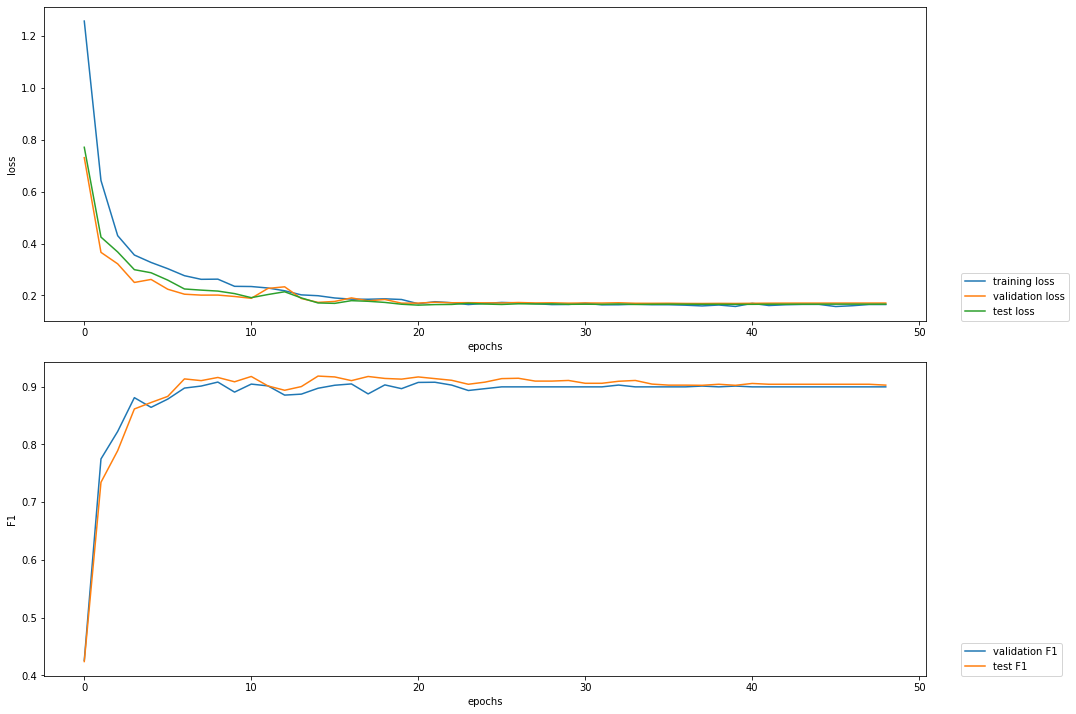

In [28]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('models/resources_v3/taggers/ner/loss.tsv')


these are looking quite promising, but clearly still not amazing just by looking at the last two.

In [29]:
# TRAINING A MODEL WITH FLAIR EMBEDDINGS TO TAKE CONTEXT INTO ACCOUNT
from flair.embeddings import FlairEmbeddings, TransformerWordEmbeddings

flair_embedding_forward = FlairEmbeddings('mix-forward')
flair_embedding_backward = FlairEmbeddings('mix-backward')

stacked_embeddings = StackedEmbeddings([
                                        glove_embedding,
                                        flair_embedding_forward,
                                        flair_embedding_backward,
                                       ])

tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=stacked_embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)

trainer : ModelTrainer = ModelTrainer(tagger, corpus)
# TRAINED
# trainer.train('models/resources_v4/taggers/ner',
#               learning_rate=0.1,
#               mini_batch_size=32,
#               max_epochs=150,
#               monitor_test=True)

2022-04-26 14:11:07,319 SequenceTagger predicts: Dictionary with 13 tags: O, S-FREQUENCY, B-FREQUENCY, E-FREQUENCY, I-FREQUENCY, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, S-MEALTIME, B-MEALTIME, E-MEALTIME, I-MEALTIME


In [30]:
model = SequenceTagger.load('models/resources_v4/taggers/ner/best-model.pt')

un_labelled.loc[:,'annotation'] = un_labelled.loc[:,'prescriber_dosage'].apply(label, args=[model])
un_labelled.loc[:,['prescriber_dosage', 'annotation']]

2022-04-26 14:11:07,456 loading file models/resources_v4/taggers/ner/best-model.pt
2022-04-26 14:11:08,696 SequenceTagger predicts: Dictionary with 10 tags: <unk>, B-QUANTITY, B-FREQUENCY, I-FREQUENCY, O, I-QUANTITY, B-MEALTIME, I-MEALTIME, <START>, <STOP>


,prescriber_dosage,annotation
1504,Take ONE capsule THREE times a day,"[(one, QUANTITY), (three times a day, FREQUENCY)]"
1505,take one capsule twice a day,"[(one, QUANTITY), (twice a day, FREQUENCY)]"
1506,"Take One Capsule Twice A Day, (One In The Morn...","[(one, QUANTITY), (twice a day, FREQUENCY)]"
1507,take one capsule twice daily,"[(one, QUANTITY), (twice daily, FREQUENCY)]"
1508,take one daily,"[(one, QUANTITY), (daily, FREQUENCY)]"
...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,"[(1, QUANTITY), (every night, FREQUENCY), (twi..."
2182,half tab nocte,"[(half, QUANTITY), (every night, FREQUENCY)]"
2183,take two at night (total dose 700mg nocte),"[(two, QUANTITY), (at night, FREQUENCY), (ever..."
2184,take one in the morning and one in the evening...,"[(one, QUANTITY), (in the morning, FREQUENCY),..."


2022-04-26 14:13:40,126 Loss and F1 plots are saved in models/resources_v3/taggers/ner/training.png


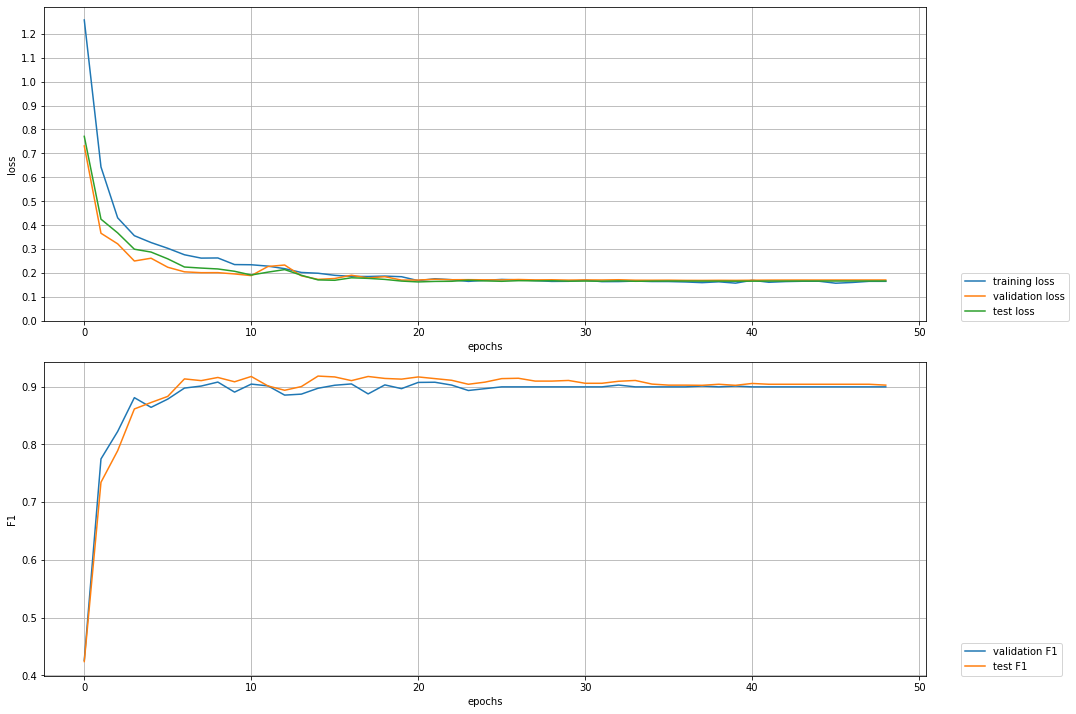

2022-04-26 14:13:41,235 Loss and F1 plots are saved in models/resources_v4/taggers/ner/training.png


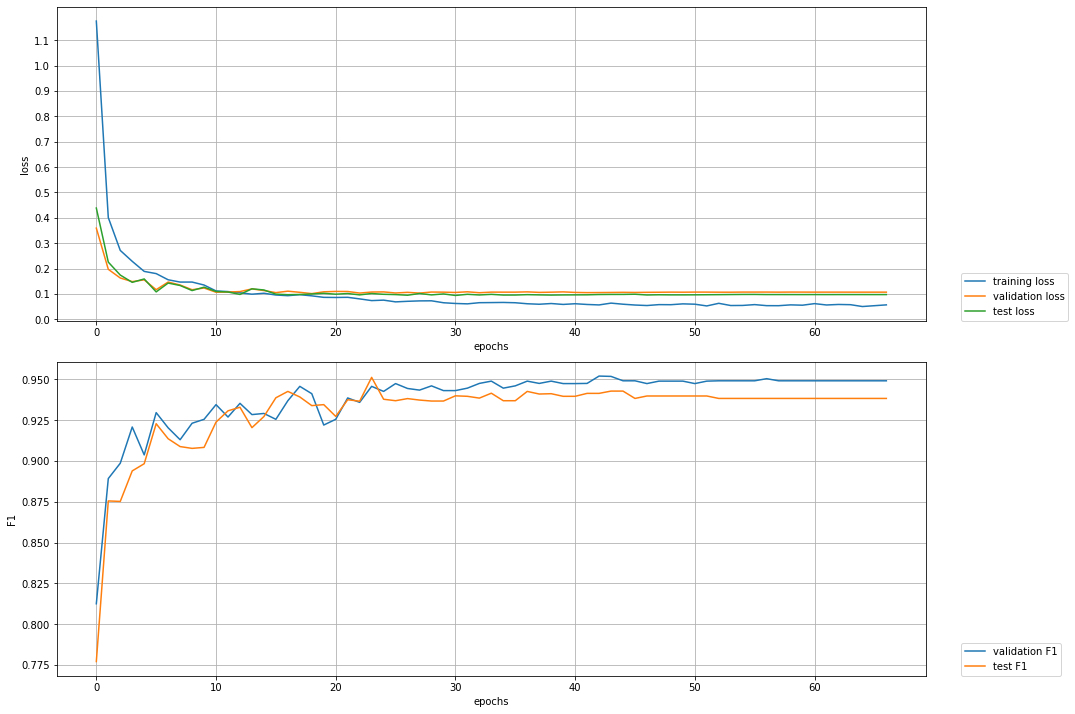

In [31]:

import matplotlib.pyplot as plt
from pathlib import Path
import csv
import logging
import math
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Union

log = logging.getLogger("flair")

# plotter = Plotter()
# plotter.plot_training_curves('models/resources_v4/taggers/ner/loss.tsv')
def _extract_evaluation_data(file_name: Union[str, Path], score: str = "F1") -> dict:
    file_name = Path(file_name)

    training_curves: Dict[str, Dict[str, List[float]]] = {
        "train": {"loss": [], "score": []},
        "test": {"loss": [], "score": []},
        "dev": {"loss": [], "score": []},
    }

    with open(file_name, "r") as f:
        tsvin = csv.reader(f, delimiter="\t")

        # determine the column index of loss, f-score and accuracy for
        # train, dev and test split
        row = next(tsvin)

        score = score.upper()

        if f"TEST_{score}" not in row:
            log.warning("-" * 100)
            log.warning(f"WARNING: No {score} found for test split in this data.")
            log.warning(f"Are you sure you want to plot {score} and not another value?")
            log.warning("-" * 100)

        TRAIN_SCORE = row.index(f"TRAIN_{score}") if f"TRAIN_{score}" in row else None
        DEV_SCORE = row.index(f"DEV_{score}") if f"DEV_{score}" in row else None
        TEST_SCORE = row.index(f"TEST_{score}") if f"TEST_{score}" in row else None

        # then get all relevant values from the tsv
        for row in tsvin:

            if TRAIN_SCORE is not None:
                if row[TRAIN_SCORE] != "_":
                    training_curves["train"]["score"].append(float(row[TRAIN_SCORE]))

            if DEV_SCORE is not None:
                if row[DEV_SCORE] != "_":
                    training_curves["dev"]["score"].append(float(row[DEV_SCORE]))

            if TEST_SCORE is not None:
                if row[TEST_SCORE] != "_":
                    training_curves["test"]["score"].append(float(row[TEST_SCORE]))

    return training_curves

def plot_training_curves(file_name: Union[str, Path], plot_values: List[str] = ["loss", "F1"]):
    file_name = Path(file_name)

    fig = plt.figure(figsize=(15, 10))

    for plot_no, plot_value in enumerate(plot_values):

        training_curves = _extract_evaluation_data(file_name, plot_value)

        plt.subplot(len(plot_values), 1, plot_no + 1)
        if training_curves["train"]["score"]:
            x = np.arange(0, len(training_curves["train"]["score"]))
            plt.plot(x, training_curves["train"]["score"], label=f"training {plot_value}")
        if training_curves["dev"]["score"]:
            x = np.arange(0, len(training_curves["dev"]["score"]))
            plt.plot(x, training_curves["dev"]["score"], label=f"validation {plot_value}")
        if training_curves["test"]["score"]:
            x = np.arange(0, len(training_curves["test"]["score"]))
            plt.plot(x, training_curves["test"]["score"], label=f"test {plot_value}")
        plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
        plt.ylabel(plot_value)
        plt.xlabel("epochs")
        if plot_value == "loss":
            plt.yticks(np.arange(0, max(training_curves["test"]["score"] + training_curves["dev"]["score"] + training_curves["train"]["score"]), 0.1))
        plt.grid()

    # save plots
    plt.tight_layout(pad=1.0)
    path = file_name.parent / "training.png"
    plt.savefig(path, dpi=300)
    log.info(f"Loss and F1 plots are saved in {path}")  # to let user know the path of the save plots
    plt.show(block=False)  # to have the plots displayed when user run this module
    plt.close(fig)

plot_training_curves('models/resources_v3/taggers/ner/loss.tsv')
plot_training_curves('models/resources_v4/taggers/ner/loss.tsv')

2022-04-26 14:13:46,656 SequenceTagger predicts: Dictionary with 13 tags: O, S-FREQUENCY, B-FREQUENCY, E-FREQUENCY, I-FREQUENCY, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, S-MEALTIME, B-MEALTIME, E-MEALTIME, I-MEALTIME
2022-04-26 14:13:47,636 Loss and F1 plots are saved in models/resources_v5/taggers/ner/training.png


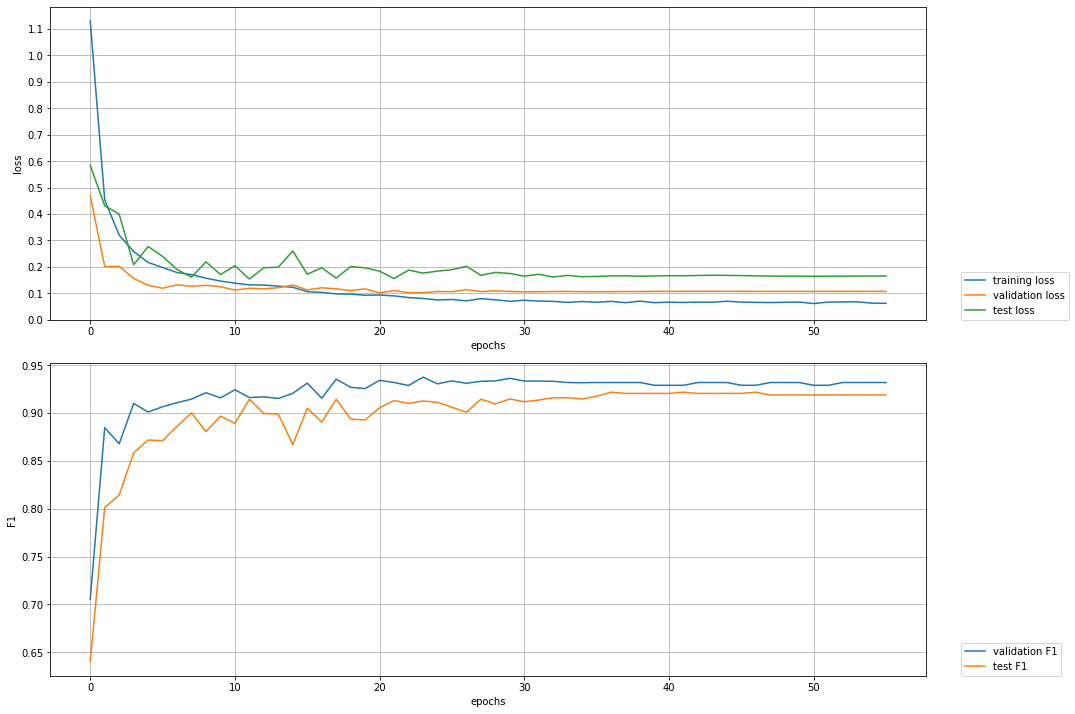

In [32]:
# Trying with transformer embeddings
transformer = TransformerWordEmbeddings('distilbert-base-uncased')

stacked_embeddings = StackedEmbeddings([
                                        glove_embedding,
                                        transformer
                                       ])

tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=stacked_embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)

trainer : ModelTrainer = ModelTrainer(tagger, corpus)
# TRAINED
# trainer.train('models/resources_v5/taggers/ner',
#               learning_rate=0.1,
#               mini_batch_size=32,
#               max_epochs=150,
#               monitor_test=True)

plot_training_curves('models/resources_v5/taggers/ner/loss.tsv')

In [33]:
model = SequenceTagger.load('models/resources_v5/taggers/ner/best-model.pt')

un_labelled.loc[:,'annotation'] = un_labelled.loc[:,'prescriber_dosage'].apply(label, args=[model])
un_labelled.loc[:,['prescriber_dosage', 'annotation']]

2022-04-26 14:13:47,855 loading file models/resources_v5/taggers/ner/best-model.pt
2022-04-26 14:13:54,274 SequenceTagger predicts: Dictionary with 10 tags: <unk>, B-QUANTITY, B-FREQUENCY, I-FREQUENCY, O, I-QUANTITY, B-MEALTIME, I-MEALTIME, <START>, <STOP>


,prescriber_dosage,annotation
1504,Take ONE capsule THREE times a day,"[(one, QUANTITY), (three times a day, FREQUENCY)]"
1505,take one capsule twice a day,"[(one, QUANTITY), (twice a day, FREQUENCY)]"
1506,"Take One Capsule Twice A Day, (One In The Morn...","[(one, QUANTITY), (twice a day, FREQUENCY), (o..."
1507,take one capsule twice daily,"[(one, QUANTITY), (twice daily, FREQUENCY)]"
1508,take one daily,"[(one, QUANTITY), (daily, FREQUENCY)]"
...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,"[(1, QUANTITY), (every night, FREQUENCY), (twi..."
2182,half tab nocte,"[(half, QUANTITY), (every night, FREQUENCY)]"
2183,take two at night (total dose 700mg nocte),"[(two, QUANTITY), (at night, FREQUENCY), (700m..."
2184,take one in the morning and one in the evening...,"[(one, QUANTITY), (in the morning, FREQUENCY),..."


In [36]:
transformer = TransformerWordEmbeddings('distilbert-base-uncased')

stacked_embeddings = StackedEmbeddings([
                                        glove_embedding,
                                        transformer
                                       ])

tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=stacked_embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)

trainer : ModelTrainer = ModelTrainer(tagger, corpus)
# TRAINED
trainer.train('models/resources_v6/taggers/ner',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150,
              monitor_test=True)

plot_training_curves('models/resources_v6/taggers/ner/loss.tsv')

2022-04-26 15:00:33,881 SequenceTagger predicts: Dictionary with 13 tags: O, S-FREQUENCY, B-FREQUENCY, E-FREQUENCY, I-FREQUENCY, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, S-MEALTIME, B-MEALTIME, E-MEALTIME, I-MEALTIME
2022-04-26 15:00:34,119 ----------------------------------------------------------------------------------------------------
2022-04-26 15:00:34,120 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): TransformerWordEmbeddings(
      (model): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0): Transfor

/opt/anaconda3/envs/mercury/lib/python3.9/site-packages/flair/trainers/trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-04-26 15:00:34,128 Model training base path: "models/resources_v6/taggers/ner"
2022-04-26 15:00:34,129 ----------------------------------------------------------------------------------------------------
2022-04-26 15:00:34,129 Device: cpu
2022-04-26 15:00:34,129 ----------------------------------------------------------------------------------------------------
2022-04-26 15:00:34,130 Embeddings storage mode: cpu
2022-04-26 15:00:34,130 ----------------------------------------------------------------------------------------------------
2022-04-26 15:00:51,549 epoch 1 - iter 3/36 - loss 3.19464183 - samples/sec: 5.51 - lr: 0.100000
2022-04-26 15:01:12,818 epoch 1 - iter 6/36 - loss 2.73310946 - samples/sec: 4.51 - lr: 0.100000
2022-04-26 15:01:28,451 epoch 1 - iter 9/36 - loss 2.54240961 - samples/sec: 6.14 - lr: 0.100000
2022-04-26 15:01:46,649 epoch 1 - iter 12/36 - loss 2.40311191 - samples/sec: 5.28 - lr: 0.100000
2022-04-26 15:02:07,575 epoch 1 - iter 15/36 - loss 2.24038713 

100%|██████████| 6/6 [00:14<00:00,  2.39s/it]

2022-04-26 15:04:28,009 Evaluating as a multi-label problem: False
2022-04-26 15:04:28,016 DEV : loss 0.4542114734649658 - f1-score (micro avg)  0.7701



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]

2022-04-26 15:04:41,316 Evaluating as a multi-label problem: False
2022-04-26 15:04:41,322 TEST : loss 0.5353717803955078 - f1-score (micro avg)  0.7205
2022-04-26 15:04:41,326 BAD EPOCHS (no improvement): 0
2022-04-26 15:04:41,327 saving best model


2022-04-26 15:04:42,451 ----------------------------------------------------------------------------------------------------
2022-04-26 15:05:02,337 epoch 2 - iter 3/36 - loss 0.68104070 - samples/sec: 4.83 - lr: 0.100000
2022-04-26 15:05:22,989 epoch 2 - iter 6/36 - loss 0.60168497 - samples/sec: 4.65 - lr: 0.100000
2022-04-26 15:05:44,466 epoch 2 - iter 9/36 - loss 0.54647139 - samples/sec: 4.47 - lr: 0.100000
2022-04-26 15:06:10,348 epoch 2 - iter 12/36 - loss 0.54012946 - samples/sec: 3.71 - lr: 0.100000
2022-04-26 15:06:30,406 epoch 2 - iter 15/36 - loss 0.54932113 - samples/sec: 4.79 - lr: 0.100000
2022-04-26 15:06:43,115 epoch 2 - iter 18/36 - loss 0.55293207 - samples/sec: 7.55 - lr: 0.100000
2022-04-26 15:07:00,907 epoch 2 - iter 21/36 - loss 0.53926615 - samples/sec: 5.40 - lr: 0.100000
2022-04-26 15:07:17,976 epoch 2 - iter 24/36 - loss 0.52568225 - samples/sec: 5.62 - lr: 0.100000
2022-04-26 15:07:37,008 epoch 2 - iter 27/36 - loss 0.51714882 - samples/sec: 5.04 - lr: 0.100

100%|██████████| 6/6 [00:14<00:00,  2.41s/it]

2022-04-26 15:08:45,585 Evaluating as a multi-label problem: False
2022-04-26 15:08:45,592 DEV : loss 0.30739548802375793 - f1-score (micro avg)  0.912



100%|██████████| 6/6 [00:13<00:00,  2.23s/it]

2022-04-26 15:08:58,985 Evaluating as a multi-label problem: False
2022-04-26 15:08:58,991 TEST : loss 0.3073955178260803 - f1-score (micro avg)  0.9091
2022-04-26 15:08:58,995 BAD EPOCHS (no improvement): 0
2022-04-26 15:08:58,996 saving best model


2022-04-26 15:09:00,276 ----------------------------------------------------------------------------------------------------
2022-04-26 15:09:21,910 epoch 3 - iter 3/36 - loss 0.40148656 - samples/sec: 4.44 - lr: 0.100000
2022-04-26 15:09:42,849 epoch 3 - iter 6/36 - loss 0.37775806 - samples/sec: 4.59 - lr: 0.100000
2022-04-26 15:09:59,146 epoch 3 - iter 9/36 - loss 0.37995863 - samples/sec: 5.89 - lr: 0.100000
2022-04-26 15:10:17,254 epoch 3 - iter 12/36 - loss 0.38088203 - samples/sec: 5.30 - lr: 0.100000
2022-04-26 15:10:36,937 epoch 3 - iter 15/36 - loss 0.36867891 - samples/sec: 4.88 - lr: 0.100000
2022-04-26 15:10:55,243 epoch 3 - iter 18/36 - loss 0.36636941 - samples/sec: 5.24 - lr: 0.100000
2022-04-26 15:11:12,975 epoch 3 - iter 21/36 - loss 0.35999152 - samples/sec: 5.41 - lr: 0.100000
2022-04-26 15:11:33,685 epoch 3 - iter 24/36 - loss 0.35379483 - samples/sec: 4.64 - lr: 0.100000
2022-04-26 15:11:49,587 epoch 3 - iter 27/36 - loss 0.35378566 - samples/sec: 6.04 - lr: 0.100

100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

2022-04-26 15:12:57,629 Evaluating as a multi-label problem: False
2022-04-26 15:12:57,636 DEV : loss 0.24687832593917847 - f1-score (micro avg)  0.9088



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:13:10,830 Evaluating as a multi-label problem: False
2022-04-26 15:13:10,835 TEST : loss 0.26444166898727417 - f1-score (micro avg)  0.8924
2022-04-26 15:13:10,840 BAD EPOCHS (no improvement): 1
2022-04-26 15:13:10,841 ----------------------------------------------------------------------------------------------------


2022-04-26 15:13:27,597 epoch 4 - iter 3/36 - loss 0.32255729 - samples/sec: 5.73 - lr: 0.100000
2022-04-26 15:13:46,496 epoch 4 - iter 6/36 - loss 0.31651361 - samples/sec: 5.08 - lr: 0.100000
2022-04-26 15:14:09,344 epoch 4 - iter 9/36 - loss 0.29038884 - samples/sec: 4.20 - lr: 0.100000
2022-04-26 15:14:26,919 epoch 4 - iter 12/36 - loss 0.27692528 - samples/sec: 5.46 - lr: 0.100000
2022-04-26 15:14:43,493 epoch 4 - iter 15/36 - loss 0.26767952 - samples/sec: 5.79 - lr: 0.100000
2022-04-26 15:15:03,095 epoch 4 - iter 18/36 - loss 0.26277589 - samples/sec: 4.90 - lr: 0.100000
2022-04-26 15:15:17,830 epoch 4 - iter 21/36 - loss 0.26665661 - samples/sec: 6.52 - lr: 0.100000
2022-04-26 15:15:34,000 epoch 4 - iter 24/36 - loss 0.26705372 - samples/sec: 5.94 - lr: 0.100000
2022-04-26 15:15:51,933 epoch 4 - iter 27/36 - loss 0.25857917 - samples/sec: 5.35 - lr: 0.100000
2022-04-26 15:16:14,488 epoch 4 - iter 30/36 - loss 0.25973355 - samples/sec: 4.26 - lr: 0.100000
2022-04-26 15:16:35,344

100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

2022-04-26 15:17:04,434 Evaluating as a multi-label problem: False
2022-04-26 15:17:04,440 DEV : loss 0.2142743319272995 - f1-score (micro avg)  0.9164



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:17:17,658 Evaluating as a multi-label problem: False
2022-04-26 15:17:17,663 TEST : loss 0.2178850919008255 - f1-score (micro avg)  0.905
2022-04-26 15:17:17,668 BAD EPOCHS (no improvement): 0
2022-04-26 15:17:17,668 saving best model


2022-04-26 15:17:18,806 ----------------------------------------------------------------------------------------------------
2022-04-26 15:17:42,915 epoch 5 - iter 3/36 - loss 0.23232975 - samples/sec: 3.98 - lr: 0.100000
2022-04-26 15:18:03,048 epoch 5 - iter 6/36 - loss 0.20056472 - samples/sec: 4.77 - lr: 0.100000
2022-04-26 15:18:19,218 epoch 5 - iter 9/36 - loss 0.21461320 - samples/sec: 5.94 - lr: 0.100000
2022-04-26 15:18:38,365 epoch 5 - iter 12/36 - loss 0.21781571 - samples/sec: 5.01 - lr: 0.100000
2022-04-26 15:18:57,474 epoch 5 - iter 15/36 - loss 0.22551186 - samples/sec: 5.02 - lr: 0.100000
2022-04-26 15:19:19,514 epoch 5 - iter 18/36 - loss 0.22545359 - samples/sec: 4.36 - lr: 0.100000
2022-04-26 15:19:42,340 epoch 5 - iter 21/36 - loss 0.22332034 - samples/sec: 4.21 - lr: 0.100000
2022-04-26 15:19:59,670 epoch 5 - iter 24/36 - loss 0.21523933 - samples/sec: 5.54 - lr: 0.100000
2022-04-26 15:20:17,207 epoch 5 - iter 27/36 - loss 0.21511743 - samples/sec: 5.47 - lr: 0.100

100%|██████████| 6/6 [00:14<00:00,  2.37s/it]

2022-04-26 15:21:20,844 Evaluating as a multi-label problem: False
2022-04-26 15:21:20,851 DEV : loss 0.19397738575935364 - f1-score (micro avg)  0.9199



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:21:34,047 Evaluating as a multi-label problem: False
2022-04-26 15:21:34,052 TEST : loss 0.19567632675170898 - f1-score (micro avg)  0.9149
2022-04-26 15:21:34,057 BAD EPOCHS (no improvement): 0
2022-04-26 15:21:34,058 saving best model


2022-04-26 15:21:35,257 ----------------------------------------------------------------------------------------------------
2022-04-26 15:21:57,603 epoch 6 - iter 3/36 - loss 0.20909936 - samples/sec: 4.30 - lr: 0.100000
2022-04-26 15:22:16,288 epoch 6 - iter 6/36 - loss 0.20451351 - samples/sec: 5.14 - lr: 0.100000
2022-04-26 15:22:32,414 epoch 6 - iter 9/36 - loss 0.17996741 - samples/sec: 5.95 - lr: 0.100000
2022-04-26 15:22:50,930 epoch 6 - iter 12/36 - loss 0.17165675 - samples/sec: 5.18 - lr: 0.100000
2022-04-26 15:23:08,042 epoch 6 - iter 15/36 - loss 0.16981154 - samples/sec: 5.61 - lr: 0.100000
2022-04-26 15:23:24,981 epoch 6 - iter 18/36 - loss 0.16318151 - samples/sec: 5.67 - lr: 0.100000
2022-04-26 15:23:45,319 epoch 6 - iter 21/36 - loss 0.16470720 - samples/sec: 4.72 - lr: 0.100000
2022-04-26 15:24:02,014 epoch 6 - iter 24/36 - loss 0.17129544 - samples/sec: 5.75 - lr: 0.100000
2022-04-26 15:24:23,115 epoch 6 - iter 27/36 - loss 0.17357336 - samples/sec: 4.55 - lr: 0.100

100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

2022-04-26 15:25:31,693 Evaluating as a multi-label problem: False
2022-04-26 15:25:31,700 DEV : loss 0.2219754159450531 - f1-score (micro avg)  0.9326



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:25:44,918 Evaluating as a multi-label problem: False
2022-04-26 15:25:44,924 TEST : loss 0.19345927238464355 - f1-score (micro avg)  0.9306
2022-04-26 15:25:44,928 BAD EPOCHS (no improvement): 0
2022-04-26 15:25:44,929 saving best model


2022-04-26 15:25:46,150 ----------------------------------------------------------------------------------------------------
2022-04-26 15:26:07,454 epoch 7 - iter 3/36 - loss 0.14625080 - samples/sec: 4.51 - lr: 0.100000
2022-04-26 15:26:24,255 epoch 7 - iter 6/36 - loss 0.13155226 - samples/sec: 5.71 - lr: 0.100000
2022-04-26 15:26:38,124 epoch 7 - iter 9/36 - loss 0.16350692 - samples/sec: 6.92 - lr: 0.100000
2022-04-26 15:26:55,228 epoch 7 - iter 12/36 - loss 0.16693096 - samples/sec: 5.61 - lr: 0.100000
2022-04-26 15:27:14,416 epoch 7 - iter 15/36 - loss 0.16367007 - samples/sec: 5.00 - lr: 0.100000
2022-04-26 15:27:32,745 epoch 7 - iter 18/36 - loss 0.16364058 - samples/sec: 5.24 - lr: 0.100000
2022-04-26 15:27:52,915 epoch 7 - iter 21/36 - loss 0.15147859 - samples/sec: 4.76 - lr: 0.100000
2022-04-26 15:28:13,491 epoch 7 - iter 24/36 - loss 0.14504215 - samples/sec: 4.67 - lr: 0.100000
2022-04-26 15:28:36,180 epoch 7 - iter 27/36 - loss 0.14505950 - samples/sec: 4.23 - lr: 0.100

100%|██████████| 6/6 [00:14<00:00,  2.37s/it]

2022-04-26 15:29:46,402 Evaluating as a multi-label problem: False
2022-04-26 15:29:46,409 DEV : loss 0.19301261007785797 - f1-score (micro avg)  0.9337



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]

2022-04-26 15:29:59,713 Evaluating as a multi-label problem: False
2022-04-26 15:29:59,719 TEST : loss 0.22436150908470154 - f1-score (micro avg)  0.9094
2022-04-26 15:29:59,723 BAD EPOCHS (no improvement): 0
2022-04-26 15:29:59,724 saving best model


2022-04-26 15:30:01,041 ----------------------------------------------------------------------------------------------------
2022-04-26 15:30:20,253 epoch 8 - iter 3/36 - loss 0.15037261 - samples/sec: 5.00 - lr: 0.100000
2022-04-26 15:30:39,941 epoch 8 - iter 6/36 - loss 0.13208330 - samples/sec: 4.88 - lr: 0.100000
2022-04-26 15:31:03,331 epoch 8 - iter 9/36 - loss 0.12774179 - samples/sec: 4.10 - lr: 0.100000
2022-04-26 15:31:21,360 epoch 8 - iter 12/36 - loss 0.13282876 - samples/sec: 5.33 - lr: 0.100000
2022-04-26 15:31:44,039 epoch 8 - iter 15/36 - loss 0.13515365 - samples/sec: 4.23 - lr: 0.100000
2022-04-26 15:32:04,550 epoch 8 - iter 18/36 - loss 0.13129307 - samples/sec: 4.68 - lr: 0.100000
2022-04-26 15:32:17,223 epoch 8 - iter 21/36 - loss 0.13439748 - samples/sec: 7.58 - lr: 0.100000
2022-04-26 15:32:37,197 epoch 8 - iter 24/36 - loss 0.13624629 - samples/sec: 4.81 - lr: 0.100000
2022-04-26 15:32:57,814 epoch 8 - iter 27/36 - loss 0.13726978 - samples/sec: 4.66 - lr: 0.100

100%|██████████| 6/6 [00:14<00:00,  2.37s/it]

2022-04-26 15:34:03,345 Evaluating as a multi-label problem: False
2022-04-26 15:34:03,351 DEV : loss 0.21816618740558624 - f1-score (micro avg)  0.9231



100%|██████████| 6/6 [00:13<00:00,  2.24s/it]

2022-04-26 15:34:16,783 Evaluating as a multi-label problem: False
2022-04-26 15:34:16,789 TEST : loss 0.1948963850736618 - f1-score (micro avg)  0.9235
2022-04-26 15:34:16,793 BAD EPOCHS (no improvement): 1
2022-04-26 15:34:16,794 ----------------------------------------------------------------------------------------------------


2022-04-26 15:34:35,792 epoch 9 - iter 3/36 - loss 0.21906942 - samples/sec: 5.05 - lr: 0.100000
2022-04-26 15:34:57,948 epoch 9 - iter 6/36 - loss 0.18523352 - samples/sec: 4.33 - lr: 0.100000
2022-04-26 15:35:15,724 epoch 9 - iter 9/36 - loss 0.16531137 - samples/sec: 5.40 - lr: 0.100000
2022-04-26 15:35:32,644 epoch 9 - iter 12/36 - loss 0.16570139 - samples/sec: 5.67 - lr: 0.100000
2022-04-26 15:35:51,082 epoch 9 - iter 15/36 - loss 0.15111302 - samples/sec: 5.21 - lr: 0.100000
2022-04-26 15:36:08,618 epoch 9 - iter 18/36 - loss 0.15105072 - samples/sec: 5.48 - lr: 0.100000
2022-04-26 15:36:24,462 epoch 9 - iter 21/36 - loss 0.14062318 - samples/sec: 6.06 - lr: 0.100000
2022-04-26 15:36:45,376 epoch 9 - iter 24/36 - loss 0.13951313 - samples/sec: 4.59 - lr: 0.100000
2022-04-26 15:37:08,678 epoch 9 - iter 27/36 - loss 0.13278069 - samples/sec: 4.12 - lr: 0.100000
2022-04-26 15:37:23,917 epoch 9 - iter 30/36 - loss 0.12739220 - samples/sec: 6.30 - lr: 0.100000
2022-04-26 15:37:43,738

100%|██████████| 6/6 [00:14<00:00,  2.38s/it]

2022-04-26 15:38:12,979 Evaluating as a multi-label problem: False
2022-04-26 15:38:12,986 DEV : loss 0.21542587876319885 - f1-score (micro avg)  0.9316



100%|██████████| 6/6 [00:13<00:00,  2.21s/it]

2022-04-26 15:38:26,262 Evaluating as a multi-label problem: False
2022-04-26 15:38:26,267 TEST : loss 0.23563452064990997 - f1-score (micro avg)  0.9094
2022-04-26 15:38:26,272 BAD EPOCHS (no improvement): 2
2022-04-26 15:38:26,272 ----------------------------------------------------------------------------------------------------


2022-04-26 15:38:47,560 epoch 10 - iter 3/36 - loss 0.24453706 - samples/sec: 4.51 - lr: 0.100000
2022-04-26 15:39:07,833 epoch 10 - iter 6/36 - loss 0.19418746 - samples/sec: 4.74 - lr: 0.100000
2022-04-26 15:39:25,330 epoch 10 - iter 9/36 - loss 0.16326155 - samples/sec: 5.49 - lr: 0.100000
2022-04-26 15:39:43,902 epoch 10 - iter 12/36 - loss 0.15101679 - samples/sec: 5.17 - lr: 0.100000
2022-04-26 15:40:02,397 epoch 10 - iter 15/36 - loss 0.13900421 - samples/sec: 5.19 - lr: 0.100000
2022-04-26 15:40:24,243 epoch 10 - iter 18/36 - loss 0.13026031 - samples/sec: 4.39 - lr: 0.100000
2022-04-26 15:40:45,824 epoch 10 - iter 21/36 - loss 0.11873455 - samples/sec: 4.45 - lr: 0.100000
2022-04-26 15:41:07,345 epoch 10 - iter 24/36 - loss 0.11909081 - samples/sec: 4.46 - lr: 0.100000
2022-04-26 15:41:21,503 epoch 10 - iter 27/36 - loss 0.12191872 - samples/sec: 6.78 - lr: 0.100000
2022-04-26 15:41:40,267 epoch 10 - iter 30/36 - loss 0.11524252 - samples/sec: 5.12 - lr: 0.100000
2022-04-26 15

100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

2022-04-26 15:42:29,397 Evaluating as a multi-label problem: False
2022-04-26 15:42:29,403 DEV : loss 0.25337469577789307 - f1-score (micro avg)  0.902



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:42:42,631 Evaluating as a multi-label problem: False
2022-04-26 15:42:42,636 TEST : loss 0.2693285048007965 - f1-score (micro avg)  0.901
2022-04-26 15:42:42,641 BAD EPOCHS (no improvement): 3
2022-04-26 15:42:42,642 ----------------------------------------------------------------------------------------------------


2022-04-26 15:42:58,077 epoch 11 - iter 3/36 - loss 0.08450690 - samples/sec: 6.22 - lr: 0.100000
2022-04-26 15:43:18,931 epoch 11 - iter 6/36 - loss 0.08954277 - samples/sec: 4.60 - lr: 0.100000
2022-04-26 15:43:40,863 epoch 11 - iter 9/36 - loss 0.09520109 - samples/sec: 4.38 - lr: 0.100000
2022-04-26 15:43:58,932 epoch 11 - iter 12/36 - loss 0.11638145 - samples/sec: 5.31 - lr: 0.100000
2022-04-26 15:44:18,709 epoch 11 - iter 15/36 - loss 0.12039822 - samples/sec: 4.85 - lr: 0.100000
2022-04-26 15:44:41,695 epoch 11 - iter 18/36 - loss 0.11657604 - samples/sec: 4.18 - lr: 0.100000
2022-04-26 15:44:58,971 epoch 11 - iter 21/36 - loss 0.11685236 - samples/sec: 5.56 - lr: 0.100000
2022-04-26 15:45:17,106 epoch 11 - iter 24/36 - loss 0.12024960 - samples/sec: 5.29 - lr: 0.100000
2022-04-26 15:45:36,873 epoch 11 - iter 27/36 - loss 0.11768292 - samples/sec: 4.86 - lr: 0.100000
2022-04-26 15:45:51,390 epoch 11 - iter 30/36 - loss 0.12135347 - samples/sec: 6.61 - lr: 0.100000
2022-04-26 15

100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

2022-04-26 15:46:42,207 Evaluating as a multi-label problem: False
2022-04-26 15:46:42,213 DEV : loss 0.16510795056819916 - f1-score (micro avg)  0.9354



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:46:55,423 Evaluating as a multi-label problem: False
2022-04-26 15:46:55,429 TEST : loss 0.25247544050216675 - f1-score (micro avg)  0.9164
2022-04-26 15:46:55,433 BAD EPOCHS (no improvement): 0
2022-04-26 15:46:55,434 saving best model


2022-04-26 15:46:56,715 ----------------------------------------------------------------------------------------------------
2022-04-26 15:47:16,171 epoch 12 - iter 3/36 - loss 0.05330639 - samples/sec: 4.94 - lr: 0.100000
2022-04-26 15:47:34,626 epoch 12 - iter 6/36 - loss 0.07249799 - samples/sec: 5.20 - lr: 0.100000
2022-04-26 15:47:51,293 epoch 12 - iter 9/36 - loss 0.07568579 - samples/sec: 5.76 - lr: 0.100000
2022-04-26 15:48:14,968 epoch 12 - iter 12/36 - loss 0.07806369 - samples/sec: 4.06 - lr: 0.100000
2022-04-26 15:48:30,110 epoch 12 - iter 15/36 - loss 0.08465896 - samples/sec: 6.34 - lr: 0.100000
2022-04-26 15:48:45,402 epoch 12 - iter 18/36 - loss 0.08497672 - samples/sec: 6.28 - lr: 0.100000
2022-04-26 15:49:03,867 epoch 12 - iter 21/36 - loss 0.08480692 - samples/sec: 5.20 - lr: 0.100000
2022-04-26 15:49:23,606 epoch 12 - iter 24/36 - loss 0.08655243 - samples/sec: 4.86 - lr: 0.100000
2022-04-26 15:49:44,636 epoch 12 - iter 27/36 - loss 0.08457963 - samples/sec: 4.57 - 

100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

2022-04-26 15:50:58,568 Evaluating as a multi-label problem: False
2022-04-26 15:50:58,574 DEV : loss 0.22768543660640717 - f1-score (micro avg)  0.933



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:51:11,772 Evaluating as a multi-label problem: False
2022-04-26 15:51:11,778 TEST : loss 0.25120809674263 - f1-score (micro avg)  0.9246
2022-04-26 15:51:11,783 BAD EPOCHS (no improvement): 1
2022-04-26 15:51:11,784 ----------------------------------------------------------------------------------------------------


2022-04-26 15:51:30,948 epoch 13 - iter 3/36 - loss 0.08406357 - samples/sec: 5.01 - lr: 0.100000
2022-04-26 15:51:48,988 epoch 13 - iter 6/36 - loss 0.09204476 - samples/sec: 5.32 - lr: 0.100000
2022-04-26 15:52:07,740 epoch 13 - iter 9/36 - loss 0.09114378 - samples/sec: 5.12 - lr: 0.100000
2022-04-26 15:52:28,703 epoch 13 - iter 12/36 - loss 0.08193794 - samples/sec: 4.58 - lr: 0.100000
2022-04-26 15:52:42,976 epoch 13 - iter 15/36 - loss 0.08597438 - samples/sec: 6.73 - lr: 0.100000
2022-04-26 15:53:04,702 epoch 13 - iter 18/36 - loss 0.07966336 - samples/sec: 4.42 - lr: 0.100000
2022-04-26 15:53:23,140 epoch 13 - iter 21/36 - loss 0.08794380 - samples/sec: 5.21 - lr: 0.100000
2022-04-26 15:53:43,123 epoch 13 - iter 24/36 - loss 0.08371120 - samples/sec: 4.80 - lr: 0.100000
2022-04-26 15:54:04,734 epoch 13 - iter 27/36 - loss 0.08380507 - samples/sec: 4.44 - lr: 0.100000
2022-04-26 15:54:25,861 epoch 13 - iter 30/36 - loss 0.08245374 - samples/sec: 4.54 - lr: 0.100000
2022-04-26 15

100%|██████████| 6/6 [00:14<00:00,  2.38s/it]

2022-04-26 15:55:07,592 Evaluating as a multi-label problem: False
2022-04-26 15:55:07,598 DEV : loss 0.28965526819229126 - f1-score (micro avg)  0.9107



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:55:20,830 Evaluating as a multi-label problem: False
2022-04-26 15:55:20,836 TEST : loss 0.3815334737300873 - f1-score (micro avg)  0.8958
2022-04-26 15:55:20,840 BAD EPOCHS (no improvement): 2
2022-04-26 15:55:20,841 ----------------------------------------------------------------------------------------------------


2022-04-26 15:55:37,583 epoch 14 - iter 3/36 - loss 0.11542935 - samples/sec: 5.73 - lr: 0.100000
2022-04-26 15:55:59,063 epoch 14 - iter 6/36 - loss 0.09769770 - samples/sec: 4.47 - lr: 0.100000
2022-04-26 15:56:19,005 epoch 14 - iter 9/36 - loss 0.09239309 - samples/sec: 4.81 - lr: 0.100000
2022-04-26 15:56:39,166 epoch 14 - iter 12/36 - loss 0.10293790 - samples/sec: 4.76 - lr: 0.100000
2022-04-26 15:56:59,131 epoch 14 - iter 15/36 - loss 0.09741322 - samples/sec: 4.81 - lr: 0.100000
2022-04-26 15:57:17,909 epoch 14 - iter 18/36 - loss 0.08981780 - samples/sec: 5.11 - lr: 0.100000
2022-04-26 15:57:36,257 epoch 14 - iter 21/36 - loss 0.08638198 - samples/sec: 5.23 - lr: 0.100000
2022-04-26 15:57:56,971 epoch 14 - iter 24/36 - loss 0.08451115 - samples/sec: 4.63 - lr: 0.100000
2022-04-26 15:58:17,970 epoch 14 - iter 27/36 - loss 0.08367483 - samples/sec: 4.57 - lr: 0.100000
2022-04-26 15:58:36,010 epoch 14 - iter 30/36 - loss 0.08039059 - samples/sec: 5.32 - lr: 0.100000
2022-04-26 15

100%|██████████| 6/6 [00:14<00:00,  2.42s/it]

2022-04-26 15:59:21,854 Evaluating as a multi-label problem: False
2022-04-26 15:59:21,860 DEV : loss 0.25575730204582214 - f1-score (micro avg)  0.9161



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 15:59:35,073 Evaluating as a multi-label problem: False
2022-04-26 15:59:35,078 TEST : loss 0.3270341157913208 - f1-score (micro avg)  0.9041
2022-04-26 15:59:35,083 BAD EPOCHS (no improvement): 3
2022-04-26 15:59:35,084 ----------------------------------------------------------------------------------------------------


2022-04-26 15:59:51,823 epoch 15 - iter 3/36 - loss 0.04063018 - samples/sec: 5.74 - lr: 0.100000
2022-04-26 16:00:06,705 epoch 15 - iter 6/36 - loss 0.04258633 - samples/sec: 6.45 - lr: 0.100000
2022-04-26 16:00:31,292 epoch 15 - iter 9/36 - loss 0.06668112 - samples/sec: 3.90 - lr: 0.100000
2022-04-26 16:00:52,714 epoch 15 - iter 12/36 - loss 0.06579919 - samples/sec: 4.48 - lr: 0.100000
2022-04-26 16:01:09,286 epoch 15 - iter 15/36 - loss 0.06846636 - samples/sec: 5.79 - lr: 0.100000
2022-04-26 16:01:26,832 epoch 15 - iter 18/36 - loss 0.06718690 - samples/sec: 5.47 - lr: 0.100000
2022-04-26 16:01:49,999 epoch 15 - iter 21/36 - loss 0.06631656 - samples/sec: 4.14 - lr: 0.100000
2022-04-26 16:06:36,930 epoch 15 - iter 24/36 - loss 0.06584098 - samples/sec: 0.33 - lr: 0.100000
2022-04-26 16:06:52,167 epoch 15 - iter 27/36 - loss 0.07084288 - samples/sec: 6.30 - lr: 0.100000
2022-04-26 16:07:10,983 epoch 15 - iter 30/36 - loss 0.07317655 - samples/sec: 5.10 - lr: 0.100000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.34s/it]

2022-04-26 16:07:59,319 Evaluating as a multi-label problem: False
2022-04-26 16:07:59,325 DEV : loss 0.23542745411396027 - f1-score (micro avg)  0.9215



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 16:08:12,512 Evaluating as a multi-label problem: False
2022-04-26 16:08:12,518 TEST : loss 0.2894918918609619 - f1-score (micro avg)  0.9091
2022-04-26 16:08:12,523 Epoch    15: reducing learning rate of group 0 to 5.0000e-02.
2022-04-26 16:08:12,523 BAD EPOCHS (no improvement): 4
2022-04-26 16:08:12,524 ----------------------------------------------------------------------------------------------------


2022-04-26 16:08:30,612 epoch 16 - iter 3/36 - loss 0.07319336 - samples/sec: 5.31 - lr: 0.050000
2022-04-26 16:08:53,937 epoch 16 - iter 6/36 - loss 0.06158764 - samples/sec: 4.12 - lr: 0.050000
2022-04-26 16:09:14,078 epoch 16 - iter 9/36 - loss 0.06545510 - samples/sec: 4.77 - lr: 0.050000
2022-04-26 16:09:37,883 epoch 16 - iter 12/36 - loss 0.06526871 - samples/sec: 4.03 - lr: 0.050000
2022-04-26 16:09:55,702 epoch 16 - iter 15/36 - loss 0.06246201 - samples/sec: 5.39 - lr: 0.050000
2022-04-26 16:10:13,692 epoch 16 - iter 18/36 - loss 0.05825741 - samples/sec: 5.34 - lr: 0.050000
2022-04-26 16:10:30,168 epoch 16 - iter 21/36 - loss 0.05797521 - samples/sec: 5.83 - lr: 0.050000
2022-04-26 16:11:17,664 epoch 16 - iter 24/36 - loss 0.05673223 - samples/sec: 2.02 - lr: 0.050000
2022-04-26 16:11:35,962 epoch 16 - iter 27/36 - loss 0.05436044 - samples/sec: 5.25 - lr: 0.050000
2022-04-26 16:15:46,689 epoch 16 - iter 30/36 - loss 0.05824353 - samples/sec: 0.38 - lr: 0.050000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.34s/it]

2022-04-26 16:16:31,541 Evaluating as a multi-label problem: False
2022-04-26 16:16:31,555 DEV : loss 0.22273533046245575 - f1-score (micro avg)  0.9284



100%|██████████| 6/6 [00:13<00:00,  2.19s/it]

2022-04-26 16:16:44,675 Evaluating as a multi-label problem: False
2022-04-26 16:16:44,681 TEST : loss 0.299188494682312 - f1-score (micro avg)  0.9192
2022-04-26 16:16:44,685 BAD EPOCHS (no improvement): 1
2022-04-26 16:16:44,686 ----------------------------------------------------------------------------------------------------


2022-04-26 16:17:03,443 epoch 17 - iter 3/36 - loss 0.04221701 - samples/sec: 5.12 - lr: 0.050000
2022-04-26 16:17:19,089 epoch 17 - iter 6/36 - loss 0.04374199 - samples/sec: 6.14 - lr: 0.050000
2022-04-26 16:17:36,809 epoch 17 - iter 9/36 - loss 0.04399577 - samples/sec: 5.42 - lr: 0.050000
2022-04-26 16:17:58,563 epoch 17 - iter 12/36 - loss 0.04309105 - samples/sec: 4.41 - lr: 0.050000
2022-04-26 16:18:19,711 epoch 17 - iter 15/36 - loss 0.04395234 - samples/sec: 4.54 - lr: 0.050000
2022-04-26 16:18:36,719 epoch 17 - iter 18/36 - loss 0.04436728 - samples/sec: 5.65 - lr: 0.050000
2022-04-26 16:18:54,320 epoch 17 - iter 21/36 - loss 0.04536613 - samples/sec: 5.45 - lr: 0.050000
2022-04-26 16:19:15,550 epoch 17 - iter 24/36 - loss 0.04719524 - samples/sec: 4.52 - lr: 0.050000
2022-04-26 16:19:38,906 epoch 17 - iter 27/36 - loss 0.04795510 - samples/sec: 4.11 - lr: 0.050000
2022-04-26 16:19:57,639 epoch 17 - iter 30/36 - loss 0.04591970 - samples/sec: 5.13 - lr: 0.050000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.37s/it]

2022-04-26 16:20:42,453 Evaluating as a multi-label problem: False
2022-04-26 16:20:42,460 DEV : loss 0.22942900657653809 - f1-score (micro avg)  0.9322



100%|██████████| 6/6 [00:13<00:00,  2.21s/it]

2022-04-26 16:20:55,708 Evaluating as a multi-label problem: False
2022-04-26 16:20:55,714 TEST : loss 0.31740421056747437 - f1-score (micro avg)  0.9174
2022-04-26 16:20:55,719 BAD EPOCHS (no improvement): 2
2022-04-26 16:20:55,719 ----------------------------------------------------------------------------------------------------


2022-04-26 16:21:13,644 epoch 18 - iter 3/36 - loss 0.01189325 - samples/sec: 5.36 - lr: 0.050000
2022-04-26 16:21:32,281 epoch 18 - iter 6/36 - loss 0.01514174 - samples/sec: 5.15 - lr: 0.050000
2022-04-26 16:21:51,074 epoch 18 - iter 9/36 - loss 0.01586022 - samples/sec: 5.11 - lr: 0.050000
2022-04-26 16:22:09,341 epoch 18 - iter 12/36 - loss 0.02680450 - samples/sec: 5.26 - lr: 0.050000
2022-04-26 16:22:32,459 epoch 18 - iter 15/36 - loss 0.02721646 - samples/sec: 4.15 - lr: 0.050000
2022-04-26 16:22:47,390 epoch 18 - iter 18/36 - loss 0.02933725 - samples/sec: 6.43 - lr: 0.050000
2022-04-26 16:23:10,175 epoch 18 - iter 21/36 - loss 0.03011564 - samples/sec: 4.21 - lr: 0.050000
2022-04-26 16:23:30,889 epoch 18 - iter 24/36 - loss 0.03035590 - samples/sec: 4.64 - lr: 0.050000
2022-04-26 16:23:54,899 epoch 18 - iter 27/36 - loss 0.03165579 - samples/sec: 4.00 - lr: 0.050000
2022-04-26 16:24:13,810 epoch 18 - iter 30/36 - loss 0.03358417 - samples/sec: 5.08 - lr: 0.050000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.35s/it]

2022-04-26 16:25:00,116 Evaluating as a multi-label problem: False
2022-04-26 16:25:00,123 DEV : loss 0.2308448702096939 - f1-score (micro avg)  0.9324



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 16:25:13,329 Evaluating as a multi-label problem: False
2022-04-26 16:25:13,336 TEST : loss 0.2888980805873871 - f1-score (micro avg)  0.9188
2022-04-26 16:25:13,340 BAD EPOCHS (no improvement): 3
2022-04-26 16:25:13,341 ----------------------------------------------------------------------------------------------------


2022-04-26 16:25:33,784 epoch 19 - iter 3/36 - loss 0.08610439 - samples/sec: 4.70 - lr: 0.050000
2022-04-26 16:25:49,685 epoch 19 - iter 6/36 - loss 0.06294019 - samples/sec: 6.04 - lr: 0.050000
2022-04-26 16:26:11,336 epoch 19 - iter 9/36 - loss 0.04921500 - samples/sec: 4.43 - lr: 0.050000
2022-04-26 16:26:29,917 epoch 19 - iter 12/36 - loss 0.05297350 - samples/sec: 5.17 - lr: 0.050000
2022-04-26 16:26:52,309 epoch 19 - iter 15/36 - loss 0.05144818 - samples/sec: 4.29 - lr: 0.050000
2022-04-26 16:27:10,875 epoch 19 - iter 18/36 - loss 0.04667334 - samples/sec: 5.17 - lr: 0.050000
2022-04-26 16:27:29,768 epoch 19 - iter 21/36 - loss 0.04279374 - samples/sec: 5.08 - lr: 0.050000
2022-04-26 16:27:49,627 epoch 19 - iter 24/36 - loss 0.04625650 - samples/sec: 4.83 - lr: 0.050000
2022-04-26 16:28:08,212 epoch 19 - iter 27/36 - loss 0.04445823 - samples/sec: 5.17 - lr: 0.050000
2022-04-26 16:28:31,407 epoch 19 - iter 30/36 - loss 0.04393735 - samples/sec: 4.14 - lr: 0.050000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.40s/it]

2022-04-26 16:29:14,593 Evaluating as a multi-label problem: False
2022-04-26 16:29:14,600 DEV : loss 0.25067371129989624 - f1-score (micro avg)  0.9424



100%|██████████| 6/6 [00:13<00:00,  2.21s/it]

2022-04-26 16:29:27,867 Evaluating as a multi-label problem: False
2022-04-26 16:29:27,874 TEST : loss 0.330086350440979 - f1-score (micro avg)  0.9131
2022-04-26 16:29:27,878 BAD EPOCHS (no improvement): 0
2022-04-26 16:29:27,879 saving best model


2022-04-26 16:29:29,168 ----------------------------------------------------------------------------------------------------
2022-04-26 16:29:49,684 epoch 20 - iter 3/36 - loss 0.04199183 - samples/sec: 4.68 - lr: 0.050000
2022-04-26 16:30:07,202 epoch 20 - iter 6/36 - loss 0.02818436 - samples/sec: 5.48 - lr: 0.050000
2022-04-26 16:30:25,571 epoch 20 - iter 9/36 - loss 0.02462054 - samples/sec: 5.23 - lr: 0.050000
2022-04-26 16:30:42,753 epoch 20 - iter 12/36 - loss 0.03245723 - samples/sec: 5.59 - lr: 0.050000
2022-04-26 16:31:05,260 epoch 20 - iter 15/36 - loss 0.03616122 - samples/sec: 4.27 - lr: 0.050000
2022-04-26 16:31:22,643 epoch 20 - iter 18/36 - loss 0.03584507 - samples/sec: 5.52 - lr: 0.050000
2022-04-26 16:31:40,827 epoch 20 - iter 21/36 - loss 0.03386701 - samples/sec: 5.28 - lr: 0.050000
2022-04-26 16:32:00,626 epoch 20 - iter 24/36 - loss 0.03447901 - samples/sec: 4.85 - lr: 0.050000
2022-04-26 16:32:22,483 epoch 20 - iter 27/36 - loss 0.03694476 - samples/sec: 4.39 - 

100%|██████████| 6/6 [00:14<00:00,  2.35s/it]

2022-04-26 16:33:26,140 Evaluating as a multi-label problem: False
2022-04-26 16:33:26,147 DEV : loss 0.2712232172489166 - f1-score (micro avg)  0.9349



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 16:33:39,344 Evaluating as a multi-label problem: False
2022-04-26 16:33:39,350 TEST : loss 0.33488982915878296 - f1-score (micro avg)  0.9233
2022-04-26 16:33:39,354 BAD EPOCHS (no improvement): 1
2022-04-26 16:33:39,355 ----------------------------------------------------------------------------------------------------


2022-04-26 16:34:00,431 epoch 21 - iter 3/36 - loss 0.03035576 - samples/sec: 4.56 - lr: 0.050000
2022-04-26 16:34:19,997 epoch 21 - iter 6/36 - loss 0.03555597 - samples/sec: 4.91 - lr: 0.050000
2022-04-26 16:34:40,843 epoch 21 - iter 9/36 - loss 0.03388595 - samples/sec: 4.61 - lr: 0.050000
2022-04-26 16:35:00,543 epoch 21 - iter 12/36 - loss 0.03364045 - samples/sec: 4.87 - lr: 0.050000
2022-04-26 16:35:23,290 epoch 21 - iter 15/36 - loss 0.03494144 - samples/sec: 4.22 - lr: 0.050000
2022-04-26 16:35:47,190 epoch 21 - iter 18/36 - loss 0.03375096 - samples/sec: 4.02 - lr: 0.050000
2022-04-26 16:36:05,079 epoch 21 - iter 21/36 - loss 0.03435053 - samples/sec: 5.37 - lr: 0.050000
2022-04-26 16:36:24,383 epoch 21 - iter 24/36 - loss 0.03151599 - samples/sec: 4.97 - lr: 0.050000
2022-04-26 16:36:46,313 epoch 21 - iter 27/36 - loss 0.03216418 - samples/sec: 4.38 - lr: 0.050000
2022-04-26 16:37:06,274 epoch 21 - iter 30/36 - loss 0.03221114 - samples/sec: 4.81 - lr: 0.050000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.39s/it]

2022-04-26 16:37:55,044 Evaluating as a multi-label problem: False
2022-04-26 16:37:55,051 DEV : loss 0.26158827543258667 - f1-score (micro avg)  0.9383



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]

2022-04-26 16:38:08,406 Evaluating as a multi-label problem: False
2022-04-26 16:38:08,413 TEST : loss 0.4120577573776245 - f1-score (micro avg)  0.9233
2022-04-26 16:38:08,418 BAD EPOCHS (no improvement): 2
2022-04-26 16:38:08,419 ----------------------------------------------------------------------------------------------------


2022-04-26 16:38:27,905 epoch 22 - iter 3/36 - loss 0.03638499 - samples/sec: 4.93 - lr: 0.050000
2022-04-26 16:38:45,605 epoch 22 - iter 6/36 - loss 0.03424254 - samples/sec: 5.42 - lr: 0.050000
2022-04-26 16:39:08,645 epoch 22 - iter 9/36 - loss 0.03044553 - samples/sec: 4.17 - lr: 0.050000
2022-04-26 16:39:24,670 epoch 22 - iter 12/36 - loss 0.03461119 - samples/sec: 5.99 - lr: 0.050000
2022-04-26 16:39:44,962 epoch 22 - iter 15/36 - loss 0.03429998 - samples/sec: 4.73 - lr: 0.050000
2022-04-26 16:40:04,117 epoch 22 - iter 18/36 - loss 0.03688228 - samples/sec: 5.01 - lr: 0.050000
2022-04-26 16:40:23,782 epoch 22 - iter 21/36 - loss 0.03606457 - samples/sec: 4.88 - lr: 0.050000
2022-04-26 16:40:47,055 epoch 22 - iter 24/36 - loss 0.03558387 - samples/sec: 4.13 - lr: 0.050000
2022-04-26 16:41:05,875 epoch 22 - iter 27/36 - loss 0.03611436 - samples/sec: 5.10 - lr: 0.050000
2022-04-26 16:41:23,167 epoch 22 - iter 30/36 - loss 0.03638374 - samples/sec: 5.55 - lr: 0.050000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.39s/it]

2022-04-26 16:42:14,361 Evaluating as a multi-label problem: False
2022-04-26 16:42:14,367 DEV : loss 0.2771134376525879 - f1-score (micro avg)  0.9362



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]

2022-04-26 16:42:27,711 Evaluating as a multi-label problem: False
2022-04-26 16:42:27,717 TEST : loss 0.39591464400291443 - f1-score (micro avg)  0.9226
2022-04-26 16:42:27,722 BAD EPOCHS (no improvement): 3
2022-04-26 16:42:27,723 ----------------------------------------------------------------------------------------------------


2022-04-26 16:42:45,470 epoch 23 - iter 3/36 - loss 0.03505568 - samples/sec: 5.41 - lr: 0.050000
2022-04-26 16:43:04,808 epoch 23 - iter 6/36 - loss 0.02464910 - samples/sec: 4.96 - lr: 0.050000
2022-04-26 16:43:24,854 epoch 23 - iter 9/36 - loss 0.02250840 - samples/sec: 4.79 - lr: 0.050000
2022-04-26 16:43:43,213 epoch 23 - iter 12/36 - loss 0.02506162 - samples/sec: 5.23 - lr: 0.050000
2022-04-26 16:44:02,621 epoch 23 - iter 15/36 - loss 0.03359666 - samples/sec: 4.95 - lr: 0.050000
2022-04-26 16:44:18,719 epoch 23 - iter 18/36 - loss 0.03536497 - samples/sec: 5.96 - lr: 0.050000
2022-04-26 16:44:43,027 epoch 23 - iter 21/36 - loss 0.03386206 - samples/sec: 3.95 - lr: 0.050000
2022-04-26 16:45:07,365 epoch 23 - iter 24/36 - loss 0.03260744 - samples/sec: 3.94 - lr: 0.050000
2022-04-26 16:45:26,243 epoch 23 - iter 27/36 - loss 0.03254437 - samples/sec: 5.09 - lr: 0.050000
2022-04-26 16:45:44,633 epoch 23 - iter 30/36 - loss 0.03464108 - samples/sec: 5.22 - lr: 0.050000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.40s/it]

2022-04-26 16:46:32,037 Evaluating as a multi-label problem: False
2022-04-26 16:46:32,044 DEV : loss 0.28663942217826843 - f1-score (micro avg)  0.9335



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 16:46:45,270 Evaluating as a multi-label problem: False
2022-04-26 16:46:45,280 TEST : loss 0.40921199321746826 - f1-score (micro avg)  0.9231
2022-04-26 16:46:45,287 Epoch    23: reducing learning rate of group 0 to 2.5000e-02.
2022-04-26 16:46:45,289 BAD EPOCHS (no improvement): 4
2022-04-26 16:46:45,292 ----------------------------------------------------------------------------------------------------


2022-04-26 16:47:05,675 epoch 24 - iter 3/36 - loss 0.01471425 - samples/sec: 4.71 - lr: 0.025000
2022-04-26 16:47:23,056 epoch 24 - iter 6/36 - loss 0.02368893 - samples/sec: 5.52 - lr: 0.025000
2022-04-26 16:47:40,590 epoch 24 - iter 9/36 - loss 0.02001737 - samples/sec: 5.48 - lr: 0.025000
2022-04-26 16:48:05,583 epoch 24 - iter 12/36 - loss 0.02200893 - samples/sec: 3.84 - lr: 0.025000
2022-04-26 16:48:23,345 epoch 24 - iter 15/36 - loss 0.02284137 - samples/sec: 5.41 - lr: 0.025000
2022-04-26 16:48:42,813 epoch 24 - iter 18/36 - loss 0.02291454 - samples/sec: 4.93 - lr: 0.025000
2022-04-26 16:49:01,651 epoch 24 - iter 21/36 - loss 0.02279188 - samples/sec: 5.10 - lr: 0.025000
2022-04-26 16:49:21,002 epoch 24 - iter 24/36 - loss 0.02266052 - samples/sec: 4.96 - lr: 0.025000
2022-04-26 16:49:41,094 epoch 24 - iter 27/36 - loss 0.02279001 - samples/sec: 4.78 - lr: 0.025000
2022-04-26 16:49:59,528 epoch 24 - iter 30/36 - loss 0.02360752 - samples/sec: 5.21 - lr: 0.025000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.41s/it]

2022-04-26 16:50:53,073 Evaluating as a multi-label problem: False
2022-04-26 16:50:53,080 DEV : loss 0.3056528568267822 - f1-score (micro avg)  0.9362



100%|██████████| 6/6 [00:13<00:00,  2.29s/it]

2022-04-26 16:51:06,808 Evaluating as a multi-label problem: False
2022-04-26 16:51:06,814 TEST : loss 0.45042261481285095 - f1-score (micro avg)  0.9231
2022-04-26 16:51:06,818 BAD EPOCHS (no improvement): 1
2022-04-26 16:51:06,820 ----------------------------------------------------------------------------------------------------


2022-04-26 16:51:24,343 epoch 25 - iter 3/36 - loss 0.03150857 - samples/sec: 5.48 - lr: 0.025000
2022-04-26 16:51:41,820 epoch 25 - iter 6/36 - loss 0.02874621 - samples/sec: 5.49 - lr: 0.025000
2022-04-26 16:52:02,553 epoch 25 - iter 9/36 - loss 0.02718676 - samples/sec: 4.63 - lr: 0.025000
2022-04-26 16:52:22,145 epoch 25 - iter 12/36 - loss 0.02894817 - samples/sec: 4.90 - lr: 0.025000
2022-04-26 16:52:41,968 epoch 25 - iter 15/36 - loss 0.02584187 - samples/sec: 4.84 - lr: 0.025000
2022-04-26 16:52:59,728 epoch 25 - iter 18/36 - loss 0.02608913 - samples/sec: 5.41 - lr: 0.025000
2022-04-26 16:53:19,527 epoch 25 - iter 21/36 - loss 0.02561329 - samples/sec: 4.85 - lr: 0.025000
2022-04-26 16:53:39,189 epoch 25 - iter 24/36 - loss 0.02323771 - samples/sec: 4.88 - lr: 0.025000
2022-04-26 16:53:57,196 epoch 25 - iter 27/36 - loss 0.02245626 - samples/sec: 5.33 - lr: 0.025000
2022-04-26 16:54:18,786 epoch 25 - iter 30/36 - loss 0.02111183 - samples/sec: 4.45 - lr: 0.025000
2022-04-26 16

100%|██████████| 6/6 [00:14<00:00,  2.42s/it]

2022-04-26 16:55:06,795 Evaluating as a multi-label problem: False
2022-04-26 16:55:06,801 DEV : loss 0.31952884793281555 - f1-score (micro avg)  0.9362



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

2022-04-26 16:55:20,016 Evaluating as a multi-label problem: False
2022-04-26 16:55:20,022 TEST : loss 0.4542566239833832 - f1-score (micro avg)  0.9274
2022-04-26 16:55:20,026 BAD EPOCHS (no improvement): 2
2022-04-26 16:55:20,027 ----------------------------------------------------------------------------------------------------


2022-04-26 16:55:40,354 epoch 26 - iter 3/36 - loss 0.04526619 - samples/sec: 4.72 - lr: 0.025000
2022-04-26 16:55:57,372 epoch 26 - iter 6/36 - loss 0.02910130 - samples/sec: 5.64 - lr: 0.025000
2022-04-26 16:56:15,859 epoch 26 - iter 9/36 - loss 0.02809105 - samples/sec: 5.19 - lr: 0.025000
2022-04-26 16:56:30,555 epoch 26 - iter 12/36 - loss 0.02725265 - samples/sec: 6.53 - lr: 0.025000
2022-04-26 16:56:51,570 epoch 26 - iter 15/36 - loss 0.02557997 - samples/sec: 4.57 - lr: 0.025000
2022-04-26 16:57:13,166 epoch 26 - iter 18/36 - loss 0.02360129 - samples/sec: 4.45 - lr: 0.025000
2022-04-26 16:57:38,167 epoch 26 - iter 21/36 - loss 0.02135453 - samples/sec: 3.84 - lr: 0.025000
2022-04-26 16:57:59,266 epoch 26 - iter 24/36 - loss 0.02017121 - samples/sec: 4.55 - lr: 0.025000
2022-04-26 16:58:18,319 epoch 26 - iter 27/36 - loss 0.02475018 - samples/sec: 5.04 - lr: 0.025000
2022-04-26 16:58:35,693 epoch 26 - iter 30/36 - loss 0.02323706 - samples/sec: 5.53 - lr: 0.025000
2022-04-26 16

100%|██████████| 6/6 [21:00<00:00, 210.15s/it]

2022-04-26 17:23:32,126 Evaluating as a multi-label problem: False
2022-04-26 17:23:32,133 DEV : loss 0.29530641436576843 - f1-score (micro avg)  0.9362



100%|██████████| 6/6 [00:12<00:00,  2.16s/it]

2022-04-26 17:23:45,075 Evaluating as a multi-label problem: False
2022-04-26 17:23:45,081 TEST : loss 0.4434884190559387 - f1-score (micro avg)  0.93
2022-04-26 17:23:45,085 BAD EPOCHS (no improvement): 3
2022-04-26 17:23:45,086 ----------------------------------------------------------------------------------------------------


2022-04-26 17:40:48,863 epoch 27 - iter 3/36 - loss 0.01125737 - samples/sec: 0.09 - lr: 0.025000
2022-04-26 17:41:07,616 epoch 27 - iter 6/36 - loss 0.01572570 - samples/sec: 5.12 - lr: 0.025000
2022-04-26 17:41:28,957 epoch 27 - iter 9/36 - loss 0.01288147 - samples/sec: 4.50 - lr: 0.025000
2022-04-26 18:00:08,265 epoch 27 - iter 12/36 - loss 0.01520391 - samples/sec: 0.09 - lr: 0.025000
2022-04-26 18:15:54,047 epoch 27 - iter 15/36 - loss 0.01871560 - samples/sec: 0.10 - lr: 0.025000
2022-04-26 18:20:13,717 epoch 27 - iter 18/36 - loss 0.01796587 - samples/sec: 0.37 - lr: 0.025000
2022-04-26 18:38:12,364 epoch 27 - iter 21/36 - loss 0.01732088 - samples/sec: 0.09 - lr: 0.025000
2022-04-26 18:53:35,902 epoch 27 - iter 24/36 - loss 0.01665056 - samples/sec: 0.10 - lr: 0.025000
2022-04-26 19:28:34,242 epoch 27 - iter 27/36 - loss 0.01668504 - samples/sec: 0.05 - lr: 0.025000
2022-04-26 19:42:14,540 epoch 27 - iter 30/36 - loss 0.01672045 - samples/sec: 0.12 - lr: 0.025000
2022-04-26 20

100%|██████████| 6/6 [15:35<00:00, 155.89s/it]

2022-04-26 20:30:24,155 Evaluating as a multi-label problem: False
2022-04-26 20:30:24,164 DEV : loss 0.33256739377975464 - f1-score (micro avg)  0.9316



100%|██████████| 6/6 [32:37<00:00, 326.18s/it]

2022-04-26 21:03:01,271 Evaluating as a multi-label problem: False
2022-04-26 21:03:01,276 TEST : loss 0.48034754395484924 - f1-score (micro avg)  0.927
2022-04-26 21:03:01,281 Epoch    27: reducing learning rate of group 0 to 1.2500e-02.
2022-04-26 21:03:01,281 BAD EPOCHS (no improvement): 4
2022-04-26 21:03:01,282 ----------------------------------------------------------------------------------------------------


2022-04-26 21:13:26,154 epoch 28 - iter 3/36 - loss 0.00790311 - samples/sec: 0.15 - lr: 0.012500
2022-04-26 21:14:07,612 epoch 28 - iter 6/36 - loss 0.01733933 - samples/sec: 2.32 - lr: 0.012500
2022-04-26 21:15:02,787 epoch 28 - iter 9/36 - loss 0.01524338 - samples/sec: 1.74 - lr: 0.012500
2022-04-26 21:16:11,847 epoch 28 - iter 12/36 - loss 0.01422080 - samples/sec: 1.39 - lr: 0.012500
2022-04-26 21:17:04,528 epoch 28 - iter 15/36 - loss 0.01331675 - samples/sec: 1.82 - lr: 0.012500
2022-04-26 21:18:05,235 epoch 28 - iter 18/36 - loss 0.01305847 - samples/sec: 1.58 - lr: 0.012500
2022-04-26 21:18:28,721 epoch 28 - iter 21/36 - loss 0.01243230 - samples/sec: 4.09 - lr: 0.012500
2022-04-26 21:18:43,879 epoch 28 - iter 24/36 - loss 0.01271067 - samples/sec: 6.33 - lr: 0.012500
2022-04-26 21:19:06,445 epoch 28 - iter 27/36 - loss 0.01487626 - samples/sec: 4.25 - lr: 0.012500
2022-04-26 21:19:30,508 epoch 28 - iter 30/36 - loss 0.01590462 - samples/sec: 3.99 - lr: 0.012500
2022-04-26 21

100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

2022-04-26 21:20:17,902 Evaluating as a multi-label problem: False
2022-04-26 21:20:17,920 DEV : loss 0.3300119638442993 - f1-score (micro avg)  0.936



100%|██████████| 6/6 [00:13<00:00,  2.19s/it]

2022-04-26 21:20:31,097 Evaluating as a multi-label problem: False
2022-04-26 21:20:31,103 TEST : loss 0.4857065975666046 - f1-score (micro avg)  0.9258
2022-04-26 21:20:31,107 BAD EPOCHS (no improvement): 1
2022-04-26 21:20:31,110 ----------------------------------------------------------------------------------------------------


2022-04-26 21:20:51,840 epoch 29 - iter 3/36 - loss 0.03316787 - samples/sec: 4.63 - lr: 0.012500
2022-04-26 21:21:11,417 epoch 29 - iter 6/36 - loss 0.02473717 - samples/sec: 4.90 - lr: 0.012500
2022-04-26 21:21:27,511 epoch 29 - iter 9/36 - loss 0.01831139 - samples/sec: 5.97 - lr: 0.012500
2022-04-26 21:21:46,411 epoch 29 - iter 12/36 - loss 0.01806015 - samples/sec: 5.08 - lr: 0.012500
2022-04-26 21:22:04,095 epoch 29 - iter 15/36 - loss 0.01580195 - samples/sec: 5.43 - lr: 0.012500


In [ ]:
# Comparing results
results_1 = pd.read_csv('models/resources/taggers/ner/loss.tsv', sep='\t')
results_2 = pd.read_csv('models/resources_v2/taggers/ner/loss.tsv', sep='\t')
results_3 = pd.read_csv('models/resources_v3/taggers/ner/loss.tsv', sep='\t')
results_4 = pd.read_csv('models/resources_v4/taggers/ner/loss.tsv', sep='\t')
results_5 = pd.read_csv('models/resources_v5/taggers/ner/loss.tsv', sep='\t')
results_6 = pd.read_csv('models/resources_v6/taggers/ner/loss.tsv', sep='\t')
# list(map( lambda x: str(x), list(range(1,len(f1_scores)+1)) ) )

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()
fig.add_trace(go.Box(y=results_1['DEV_F1'].values, name='Small (~100) (glove Embeddings)'))
fig.add_trace(go.Box(y=results_2['DEV_F1'].values, name='Small (~200) (glove Embeddings)'))
fig.add_trace(go.Box(y=results_3['DEV_F1'].values, name='Large (~1500) (glove Embeddings)'))
fig.add_trace(go.Box(y=results_4['DEV_F1'].values, name='Large (~1500) (glove + Flair Embeddings)'))
fig.add_trace(go.Box(y=results_5['DEV_F1'].values, name='Large (~1500) (glove + distilBERT Embeddings)'))
fig.add_trace(go.Box(y=results_6['DEV_F1'].values, name='Large (~1500) (FLAIR Embeddings)'))
fig.update_layout(
    title={
    'text': "Validation Set F1 scores",
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    height=600,
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0.4,
        dtick = 0.05
    )
)
fig.show()
fig2 = go.Figure()
fig2.add_trace(go.Box(y=results_3['TEST_F1'].values, name='Large (~1500) (glove Embeddings)'))
fig2.add_trace(go.Box(y=results_4['TEST_F1'].values, name='Large (~1500) (glove + Flair Embeddings)'))
fig2.add_trace(go.Box(y=results_5['TEST_F1'].values, name='Large (~1500) (glove + distilBERT Embeddings)'))
fig2.add_trace(go.Box(y=results_6['TEST_F1'].values, name='Large (~1500) (FLAIR Embeddings)'))
fig2.update_layout(
    title={
        'text': "Test Set F1 scores",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    height=600,
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0.6,
        dtick = 0.05
    )
)
fig2.show()

fig3 = go.Figure()
fig3.add_trace(go.Box(y=results_4['TEST_F1'].values, name='Large (~1500) (glove + Flair Embeddings)'))
fig3.add_trace(go.Box(y=results_5['TEST_F1'].values, name='Large (~1500) (glove + distilBERT Embeddings)'))
fig3.add_trace(go.Box(y=results_6['TEST_F1'].values, name='Large (~1500) (FLAIR Embeddings)'))
fig3.update_layout(
    title={
        'text': "Test Set F1 scores (Higher performers)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    height=600,
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0.6,
        dtick = 0.05
    )
)
fig3.show()

In [ ]:
# get unique frequency values from whole data set. so i can look at what RRules I need to set up.
# Model scores tend to change with FLAIR and DISTILBERT embeddings becoming somewhat interchangeable, so 
if results_4['TEST_F1'].max() > results_5['TEST_F1'].max():
    print('FLAIR MODEL')
    best_model = SequenceTagger.load('models/resources_v4/taggers/ner/best-model.pt') # FLAIR embedding model
else:
    print('TRANFORMER EMBEDDING MODEL')
    best_model = SequenceTagger.load('models/resources_v5/taggers/ner/best-model.pt') # DISTILBERT embedding model

whole_set.loc[:,'annotation'] = whole_set.loc[:,'prescriber_dosage'].apply(label, args=[best_model])
whole_set.to_csv('data/labelled_set_v2_corrected_flair_model.csv')

FLAIR MODEL
2022-04-21 10:34:52,189 loading file models/resources_v4/taggers/ner/best-model.pt
2022-04-21 10:34:55,295 SequenceTagger predicts: Dictionary with 10 tags: <unk>, B-QUANTITY, B-FREQUENCY, I-FREQUENCY, O, I-QUANTITY, B-MEALTIME, I-MEALTIME, <START>, <STOP>


In [ ]:
frequencies = [item[0] for list in whole_set.loc[:,'annotation'].tolist() for item in list if item[1] == 'FREQUENCY']
frequencies

['daily',
 '4 times a day',
 'twice daily',
 'every 7 days',
 'every 4-6 hours',
 '8 in 24 hours',
 '7 day',
 '3 times day',
 '7 day',
 '4 times day',
 'three times a day',
 '4 times a day',
 'daily',
 'each day',
 'once weekly',
 'daily',
 'daily',
 'twice daily',
 'four times a day',
 'four times a day',
 'four times a day',
 'daily',
 'four times a day',
 'four times a day',
 'four times a day',
 'four times a dayprn',
 'four times a day',
 'once daily',
 'four times a day',
 'four times a day',
 'four times a day',
 'four times a day',
 'twice a day',
 '4 times a day',
 'four times a day',
 'three times a day',
 'four times a day',
 'four times a day',
 'a day',
 'a day',
 'daily',
 'a month',
 'a week',
 'alt days',
 'alternate days',
 'a month',
 'three times a day',
 'twice a day',
 'twice daily',
 'twice daily',
 'twice daily',
 'once a day',
 'twice daily',
 'daily',
 'every day',
 'once daily',
 '3 times a day',
 'every 6 hours',
 'every 8 hours',
 'every morning',
 'once a d

In [ ]:
unique_values = set(frequencies)

Mapping frequency to RRule:

I think the best thing to do is to come up with RRules that are most relevant. x times a day, every x hours.

First I need to split everything up into 3 categories, frequency, frequency with time of day, other

In [ ]:
from word2number.w2n import word_to_num as w2n
import inflect

p = inflect.engine()


def post_process(sentence: str): #should have done this before tbh 
    sentence = Sentence(sentence)
    new_string = []
    for i in range(len(sentence)):
        token = sentence[i].text
        try:
            number = p.number_to_words(int(token))
            new_string.append(str(number))
        except:
            new_string.append(token)
    return ' '.join(new_string)
            
processed_values = []
for string in unique_values:
    processed_values.append(post_process(string))

unique_values = list(set(processed_values))
len(unique_values)

142

In [ ]:
rrules = pd.read_csv('data/rrules.csv')
standard = rrules.loc[:, 'text'].to_list()
standard

['once weekly',
 'twice weekly',
 'three times weekly',
 'every other day',
 'once daily',
 'twice daily',
 'three times daily',
 'four times daily',
 'five times daily',
 'every morning',
 'every night']

In [ ]:
# embed sentences using a model, calculate similarity between sentences using cosine_similarity
#  CITE: https://www.sbert.net/index.html
from sklearn.metrics.pairwise import cosine_similarity

# using sentence_transformer package as it works better with lists for whole sentences, flair we would have to concatenate all strings
# This framework provides an easy method to compute dense vector representations for sentences, paragraphs, and images. 
# The models are based on transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. and achieve state-of-the-art performance in various task. 
# Text is embedding in vector space such that similar text is close and can efficiently be found using cosine similarity.

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('multi-qa-mpnet-base-dot-v1') # highest score in semantic search
rrules.loc[:, 'embeddings'] = rrules.loc[:, 'text'].apply(model.encode)

In [ ]:
def find_most_similar(string: str):
    embeddings_stan  = rrules.loc[:, 'embeddings'].to_list()
    difference =  cosine_similarity([model.encode(string)], embeddings_stan)
    index = difference[0].argmax()
    return rrules.iloc[index].loc['text'], difference[0][index]

freq = []
match = []
for each in unique_values:
    freq.append(each)
    match.append(find_most_similar(each))

pre_trained_matches = pd.DataFrame({'string': freq, 'pre-trained match': match})
pre_trained_matches

,string,pre-trained match
0,once every night,"(once daily, 0.8245864)"
1,five times day,"(five times daily, 0.9587241)"
2,one weekly,"(once weekly, 0.88382715)"
3,early evening,"(every night, 0.53193414)"
4,two times day,"(twice daily, 0.86788356)"
...,...,...
137,once a week,"(once weekly, 0.8903437)"
138,five hours,"(five times daily, 0.6522585)"
139,once a day each morning,"(once daily, 0.84654903)"
140,daily,"(once daily, 0.79377365)"


As can be seen, pre-trained models work to a certain extent but there is still much room for improvement eg. 'every 4-6 hours' maps to 'twice daily'. I will need to train custom embeddings.

In [ ]:
find_most_similar('every 4-6 hours')

('twice daily', 0.7603087)

In [ ]:
# after labelling a semantic textual similarity training set
# I will apply that mapping to every single datapoint in frequency to create a dataset of ~1900
# train a transformer embedding model on this dataset
mapping_dict = pd.read_csv('data/mapping_training_data.csv')
mapping_dict.set_index('string', inplace=True)

In [ ]:
datapoints = []
for string in frequencies:
    processed_string = post_process(string)
    try:
        data = mapping_dict.loc[processed_string].to_list()
        data.insert(0,processed_string)
        datapoints.append(data)
    except:
        print('No match found for: ', processed_string)

columns = standard.copy()
columns.insert(0,'string')
len(columns)
mapping_training_data_full = pd.DataFrame(datapoints, columns=columns)
mapping_training_data_full

No match found for:  eight in twenty-four hours
No match found for:  in the morning
No match found for:  day
No match found for:  in the morning
No match found for:  once at night
No match found for:  four x a day
No match found for:  with meals
No match found for:  to
No match found for:  a
No match found for:  ten minutes
No match found for:  a
No match found for:  a
No match found for:  a
No match found for:  at night
No match found for:  once a day every morning
No match found for:  in the morning
No match found for:  in the morning
No match found for:  at night
No match found for:  at night
No match found for:  eight in twenty-four hours
No match found for:  in the morning
No match found for:  at night
No match found for:  in the morning
No match found for:  in the morning
No match found for:  in the morning
No match found for:  in the morning
No match found for:  each day every morning
No match found for:  each day every night
No match found for:  in the evening
No match found fo

,string,once weekly,twice weekly,three times weekly,every other day,once daily,twice daily,three times daily,four times daily,five times daily,every morning,every night
0,daily,0,0,0,0,5,0,0,0,0,0,0
1,four times a day,0,0,0,0,1,3,3,5,3,1,1
2,twice daily,0,1,0,0,1,5,1,1,1,0,0
3,every seven days,5,1,1,1,0,0,0,0,0,0,0
4,every 4-6 hours,0,0,0,0,0,3,3,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1965,every night,0,0,0,0,4,0,0,0,0,0,5
1966,every night,0,0,0,0,4,0,0,0,0,0,5
1967,every morning,0,0,0,0,1,0,0,0,0,5,0
1968,every night,0,0,0,0,4,0,0,0,0,0,5


In [ ]:
from sentence_transformers import SentencesDataset, InputExample, losses, util
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# https://arxiv.org/abs/2010.08240
# creating training sentence pairs
data_pairs=[]
for index, row in mapping_training_data_full.iterrows():
    string = row['string']
    for column, value in row.items():
        if column != 'string':
            data_pairs.append(InputExample(texts=[string, column], label=value/5))
training_pairs, test_pairs = train_test_split(data_pairs, test_size=0.33, random_state=1)

In [ ]:
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import math
train_dataloader = DataLoader(training_pairs, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_pairs, name='dev')
#Tune the model
# model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10, warmup_steps=100, )
train_batch_size = 16
num_epochs = 1
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1)
# model.fit(train_objectives=[(train_dataloader, train_loss)],
#           evaluator=evaluator,
#           epochs=num_epochs,
#           evaluation_steps=1000,
#           warmup_steps=warmup_steps,
#           output_path='final_model_choice/sts-model')

In [ ]:
model = SentenceTransformer('final_model_choice/sts-model')
rrules.loc[:, 'embeddings'] = rrules.loc[:, 'text'].apply(model.encode)
def find_most_similar(string: str):
    embeddings_stan  = rrules.loc[:, 'embeddings'].to_list()
    difference =  cosine_similarity([model.encode(string)], embeddings_stan)
    index = difference[0].argmax()
    return rrules.iloc[index].loc['text'], difference[0][index]

freq = []
match = []
for each in unique_values:
    freq.append(each)
    match.append((find_most_similar(each)))

test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_pairs, name='sts-test')
test_evaluator(model, output_path='final_model_choice/sts-model')

0.8365065014619644

In [ ]:
custom_matches = pd.DataFrame({'cutom_match': match})


In [ ]:
pd.concat([pre_trained_matches, custom_matches], axis = 1)

,string,pre-trained match,cutom_match
0,once every night,"(once daily, 0.8245864)","(every night, 0.98539037)"
1,five times day,"(five times daily, 0.9587241)","(five times daily, 0.96563417)"
2,one weekly,"(once weekly, 0.88382715)","(once weekly, 0.9868854)"
3,early evening,"(every night, 0.53193414)","(every night, 0.810167)"
4,two times day,"(twice daily, 0.86788356)","(twice daily, 0.7460866)"
...,...,...,...
137,once a week,"(once weekly, 0.8903437)","(once weekly, 0.5917779)"
138,five hours,"(five times daily, 0.6522585)","(five times daily, 0.755965)"
139,once a day each morning,"(once daily, 0.84654903)","(every morning, 0.87832487)"
140,daily,"(once daily, 0.79377365)","(once daily, 0.7387885)"


Each number represents the degree of similarity between the string, and the nearest match. I think the custom model suits the task much more, for example 'per twenty-four hours' is not very similar to 'four times daily' but still recieves a similarity score of 0.58, whereas the custom_match detects a match with 'twice daily' with low confidence which is much more representative.

In [ ]:
def get_similarity(string1, string2):
    model = SentenceTransformer('final_model_choice/sts-model')
    return cosine_similarity([model.encode(string1)], [model.encode(string2)])
def get_pretrained_similarity(string1, string2):
    model = SentenceTransformer('final_model_choice/sts-model')
    return cosine_similarity([model.encode(string1)], [model.encode(string2)])
    
get_similarity('three times', 'thrice')[0][0]
find_most_similar('tabletat night')

('every night', 0.7092597)

In [ ]:
# data that was not labelled during training, untouched.
import nltk
from flair.data import Sentence
from flair.models import SequenceTagger
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sentence_transformers import SentenceTransformer
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *
import inflect

p = inflect.engine()
import os

tokenizer = nltk.RegexpTokenizer(r"[\w'-]+")

# for some reason the current working directory accoding to python is not normalisation-project bu loop-webapps

# this defines the best model for
best_model_ner = SequenceTagger.load('final_model_choice/taggers/ner/best-model.pt') # FLAIR embedding model

# this defines our trained model for STS
try:
    model_sts = SentenceTransformer('final_model_choice/sts-model')
except:
    model_sts = SentenceTransformer('sts-model')

tokenizer = nltk.RegexpTokenizer(r"[\w'-]+")

# this defines our standard string mappping to RRule

rrule_dict ={
    "once weekly":"FREQ=WEEKLY;BYDAY=MO",
    "twice weekly":"FREQ=WEEKLY;BYDAY=TU,FR",
    "three times weekly":"FREQ=WEEKLY;BYDAY=TU,TH,SU",
    "every other day": "FREQ=DAILY;INTERVAL=2;BYHOUR=9",
    "once daily":"FREQ=DAILY;BYHOUR=9",
    "twice daily":"FREQ=DAILY;BYHOUR=8,20",
    "three times daily":"FREQ=DAILY;BYHOUR=8,13,18",
    "four times daily":"FREQ=DAILY;BYHOUR=8,12,16,20",
    "five times daily":"FREQ=DAILY;BYHOUR=8,11,14,17,20",
    "every morning":"FREQ=DAILY;BYHOUR=9",
    "every night":"FREQ=DAILY;BYHOUR=21",
}

rrules_df = pd.DataFrame.from_dict(rrule_dict, orient='index', columns=['rrule']).reset_index()
rrules_df.columns = ['text', 'rrule']
rrules_df.loc[:, 'embeddings'] = rrules_df.loc[:, 'text'].apply(model_sts.encode)

# this defines the dictionary for medical abbreviations
f = open('data/abbreviations.txt', "r")

abb_dict = {}
multiple_abbreviations = []

def configure_abreviations(line):
    strings = line.split(':')
    long_form = ' '.join(strings[1].split())
    if len(long_form.split('/'))>1:
        print(long_form.split('/'))
    abbreviation_list=strings[0].split(',')
    if len(abbreviation_list) > 1:
        multiple_abbreviations.append(abbreviation_list)
    abb = abbreviation_list[0] if len(abbreviation_list) == 1 else abbreviation_list[1]
    abbreviation, text = ' '.join(abb.split()), long_form
    abb_dict[abbreviation] = text

[configure_abreviations(line) for line in f]
multiple_abb_mapping = [(','.join(abb),abb[1]) for abb in multiple_abbreviations]

abb_mappings_dict = {}
for mapping in multiple_abb_mapping:
    temp = list(map(lambda x : x.split(),mapping[0].split(',')))
    key = [item for sublist in temp for item in sublist]
    abb_mappings_dict[tuple(key)] = ''.join(mapping[1].split())

def process(text):
    tokens = list(map(lambda x: x.casefold(), tokenizer.tokenize(text)))
    keys1 = abb_mappings_dict.keys() # multiple abbreviations
    for i in range(len(tokens)):
        token = tokens[i]
        mult_abb = next((x for x in keys1 if token in x), None)
        if mult_abb != None:
            token = abb_mappings_dict[mult_abb]
        
        if token in abb_dict.keys():
            tokens[i] = abb_dict[token]
    
    return ' '.join(tokens)

def post_process(sentence: str):
    sentence = Sentence(sentence)
    new_string = []
    for i in range(len(sentence)):
        token = sentence[i].text
        try:
            number = p.number_to_words(int(token))
            new_string.append(str(number))
        except:
            new_string.append(token)
    return ' '.join(new_string)

def label(text, model):
    # run NER over sentence
    text=Sentence(process(text))
    model.predict(text)
    ents = [(entity.text, entity.get_label("ner").value) for entity in text.get_spans('ner')] #getting NER spans
    return ents

def find_match(string: str, model):
    embeddings_stan  = rrules_df.loc[:, 'embeddings'].to_list()
    difference =  cosine_similarity([model.encode(string)], embeddings_stan)
    index = difference[0].argmax()
    return index, rrules_df.iloc[index].loc['text'], difference[0][index]

def current_time_string():
    datetime_string = datetime.now().__str__()
    date_string = datetime_string.split()[0].split('-')
    time_string = datetime_string.split()[1].split(':')
    time_string[-1] = '00'
    time_string[-2] = '00'
    return ''.join(date_string+["T"]+time_string)

def take_times(rrule_string: str, start: str, occurences: int = 7):
    # can take set amount prescribed as occurences and schedule will stop when presciption
    count = ";COUNT=" + str(occurences)
    return list(rrulestr( rrule_string+count, dtstart=parse(start) ))

def schedule(string: str, start: str = current_time_string()):
    labels = label(process(string), best_model_ner)
    frequencies = [post_process(item[0]) for item in labels if item[1] == 'FREQUENCY']
    try:
        frequency = frequencies[0]
        processed_frequency = post_process(frequency)
        match_index, match, similarity = find_match(processed_frequency, model_sts)
        return list(map(lambda x: x.__str__(), take_times(rrules_df.iloc[match_index].loc['rrule'], start)))
    except ParserError:
        return 'Invalid start time: '+ start
    except IndexError: # probably means that there are no frequencies
        return 'No frequencies found.'
    except:
        return 'Error: invalid input'

def schedule_datetimes(string: str, start: str = current_time_string()):
    labels = label(process(string), best_model_ner)
    frequencies = [post_process(item[0]) for item in labels if item[1] == 'FREQUENCY']
    try:   
        frequency = frequencies[0]
        processed_frequency = post_process(frequency)
        match_index, match, similarity = find_match(processed_frequency, model_sts)
        return take_times(rrules_df.iloc[match_index].loc['rrule'], start, 50)
    except ParserError:
        return 'Invalid start time: '+ start
    except IndexError: # probably means that there are no frequencies
        return 'No frequencies found.'
    except:
        return frequencies

def get_rrule(string: str):
    labels = label(process(string), best_model_ner)
    frequencies = [post_process(item[0]) for item in labels if item[1] == 'FREQUENCY']
    try:   
        frequency = frequencies[0]
        processed_frequency = post_process(frequency)
        match_index, match, similarity = find_match(processed_frequency, model_sts)
        return rrules_df.iloc[match_index].loc['rrule']
    except:
        return frequencies


2022-04-21 11:04:12,540 loading file final_model_choice/taggers/ner/best-model.pt
2022-04-21 11:04:15,085 SequenceTagger predicts: Dictionary with 10 tags: <unk>, B-QUANTITY, B-FREQUENCY, I-FREQUENCY, O, I-QUANTITY, B-MEALTIME, I-MEALTIME, <START>, <STOP>


In [ ]:
datetimes = whole_set.iloc[1504:].loc[:,'prescriber_dosage'].apply(schedule_datetimes)
rrules_column = whole_set.iloc[1504:].loc[:,'prescriber_dosage'].apply(get_rrule)

In [ ]:
untouched = whole_set.iloc[1504:]
untouched.loc[:,'datetimes']=datetimes
untouched.loc[:,'rrule']=rrules_column
untouched.drop('string', axis=1, inplace=True)
untouched

/var/folders/89/d0d2vvw54hn9r2smx5prxgrm0000gn/T/ipykernel_10954/2455779331.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/89/d0d2vvw54hn9r2smx5prxgrm0000gn/T/ipykernel_10954/2455779331.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/89/d0d2vvw54hn9r2smx5prxgrm0000gn/T/ipykernel_10954/2455779331.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

,prescriber_dosage,annotation,datetimes,rrule
1504,Take ONE capsule THREE times a day,"[(one, QUANTITY), (three times a day, FREQUENCY)]","[2022-04-21 13:00:00, 2022-04-21 18:00:00, 202...","FREQ=DAILY;BYHOUR=8,13,18"
1505,take one capsule twice a day,"[(one, QUANTITY), (twice a day, FREQUENCY)]","[2022-04-21 20:00:00, 2022-04-22 08:00:00, 202...","FREQ=DAILY;BYHOUR=8,20"
1506,"Take One Capsule Twice A Day, (One In The Morn...","[(one, QUANTITY), (twice a day, FREQUENCY)]","[2022-04-21 20:00:00, 2022-04-22 08:00:00, 202...","FREQ=DAILY;BYHOUR=8,20"
1507,take one capsule twice daily,"[(one, QUANTITY), (twice daily, FREQUENCY)]","[2022-04-21 20:00:00, 2022-04-22 08:00:00, 202...","FREQ=DAILY;BYHOUR=8,20"
1508,take one daily,"[(one, QUANTITY), (daily, FREQUENCY)]","[2022-04-22 09:00:00, 2022-04-23 09:00:00, 202...",FREQ=DAILY;BYHOUR=9
...,...,...,...,...
2181,1 nocte## please do u&e twice a year in jan an...,"[(1, QUANTITY), (every night, FREQUENCY), (twi...","[2022-04-21 21:00:00, 2022-04-22 21:00:00, 202...",FREQ=DAILY;BYHOUR=21
2182,half tab nocte,"[(half, QUANTITY), (every night, FREQUENCY)]","[2022-04-21 21:00:00, 2022-04-22 21:00:00, 202...",FREQ=DAILY;BYHOUR=21
2183,take two at night (total dose 700mg nocte),"[(two, QUANTITY), (at night, FREQUENCY), (ever...","[2022-04-21 21:00:00, 2022-04-22 21:00:00, 202...",FREQ=DAILY;BYHOUR=21
2184,take one in the morning and one in the evening...,"[(one, QUANTITY), (in the morning, FREQUENCY),...","[2022-04-22 09:00:00, 2022-04-23 09:00:00, 202...",FREQ=DAILY;BYHOUR=9


In [ ]:
untouched.to_json('feedbackData.json', orient='records')

In [ ]:
untouched = pd.read_json('feedbackData.json', orient='records')

In [ ]:
untouched.sample(5).drop('datetimes', axis=1)

,prescriber_dosage,annotation,rrule
16,take one daily *Repeat Dispensed*,"[[one, QUANTITY], [daily, FREQUENCY]]",FREQ=DAILY;BYHOUR=9
7,TAKE ONE DAILY ## FOR LFT CHECK EVERY A...,"[[one, QUANTITY], [daily, FREQUENCY], [every a...",FREQ=DAILY;BYHOUR=9
517,1 in the morning and one nocte in addition to ...,"[[1, QUANTITY], [every night, FREQUENCY]]",FREQ=DAILY;BYHOUR=21
198,take one with breakfast,"[[one, QUANTITY], [with breakfast, MEALTIME]]",[]
285,To Be Taken As Directed,[],[]


In [ ]:
untouched.iloc[[636, 540, 662, 416, 576, 371, 122, 65]].drop('datetimes', axis=1).to_csv('example_results.csv', index=False)

In [ ]:
# mistakes
untouched.iloc[[518, 467]].drop('datetimes', axis=1).to_csv('example_failed_results.csv', index=False)